# Importing necessary libraries

In [1]:
import os, sys, copy, helper, warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from PIL import Image
import cv2
import csv


import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models, utils
from torchvision.utils import make_grid

import imageio
from sklearn.metrics import confusion_matrix
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

In [2]:
def show_images(dataloader): 
    for images, labels in dataloader:
        fig, ax = plt.subplots(figsize=(16,16))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=5).permute(1, 2, 0))
        break

def accuracy(output, target):
    output = torch.exp(output)
    top_p,top_class = output.topk(1,dim = 1)
    equals = top_class == target.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [3]:
train_on_gpu = torch.cuda.is_available()
train_on_gpu

True

In [4]:
!nvidia-smi

/bin/bash: /home/sysadm/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Sat Jun 25 03:19:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro GV100        On   | 00000000:2D:00.0  On |                  Off |
| 39%   52C    P0    47W / 250W |    309MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+--

# Setting necessary paths

In [5]:
path = '/home/sysadm/Documents/3ml_kkm/env/chest_xray'
train_dir = path + '/train'
test_dir = path + '/test'

# Creating dataframe with data stats

In [6]:
n_train = []
n_test = []
classes = ['PNEUMONIA', 'NORMAL']
for c in classes:
    train_images = os.listdir(train_dir + '/' + c)
    n_train.append(len(train_images))
    test_images = os.listdir(test_dir + '/' + c)
    n_test.append(len(test_images))
  

In [7]:
print(n_train)
print(n_test)

[3884, 1349]
[390, 235]


In [8]:
data = pd.DataFrame({'Classes' : classes,
                      'Train' : n_train,
                      'Test' : n_test})
print(data)

     Classes  Train  Test
0  PNEUMONIA   3884   390
1     NORMAL   1349   235



# Visualising data stats

In [9]:
# plt.figure(figsize=(8,8))
# sns.barplot(data=data, x='Classes', y='Train')
# plt.xlabel('Classes',fontsize=15)
# plt.ylabel('Count',fontsize=15)
# plt.title('Training data',fontsize=15);

In [10]:
# plt.figure(figsize=(8,8))
# sns.barplot(data=data, x='Classes', y='Test')
# plt.xlabel('Classes',fontsize=15)
# plt.ylabel('Count',fontsize=15)
# plt.title('Test data',fontsize=15);

# Creating dataframe from images and labels


In [11]:
# train set

ptrain = []
ctrain = []
for folder_name in classes:
    for files in os.listdir(train_dir + '/' + folder_name):
        if files.split(".")[-1].lower() in {"jpeg", "jpg", "png"}:
            path = train_dir + '/' + folder_name + '/' + files
            clss = folder_name
            ptrain.append(path)
            ctrain.append(clss)


# test set

ptest = []
ctest = []
for folder_name in classes:
    for files in os.listdir(test_dir + '/' + folder_name):
        if files.split(".")[-1].lower() in {"jpeg", "jpg", "png"}:
            path = test_dir + '/' + folder_name + '/' + files
            clss = folder_name
            ptest.append(path)
            ctest.append(clss)

In [12]:
train_df = pd.DataFrame({'Path':ptrain,'Class':ctrain})
test_df = pd.DataFrame({'Path':ptest,'Class':ctest})
train_df.head(10)


Path      Class
0  /home/sysadm/Documents/3ml_kkm/env/chest_xray/...  PNEUMONIA
1  /home/sysadm/Documents/3ml_kkm/env/chest_xray/...  PNEUMONIA
2  /home/sysadm/Documents/3ml_kkm/env/chest_xray/...  PNEUMONIA
3  /home/sysadm/Documents/3ml_kkm/env/chest_xray/...  PNEUMONIA
4  /home/sysadm/Documents/3ml_kkm/env/chest_xray/...  PNEUMONIA
5  /home/sysadm/Documents/3ml_kkm/env/chest_xray/...  PNEUMONIA
6  /home/sysadm/Documents/3ml_kkm/env/chest_xray/...  PNEUMONIA
7  /home/sysadm/Documents/3ml_kkm/env/chest_xray/...  PNEUMONIA
8  /home/sysadm/Documents/3ml_kkm/env/chest_xray/...  PNEUMONIA
9  /home/sysadm/Documents/3ml_kkm/env/chest_xray/...  PNEUMONIA

# Data to csv

In [13]:
train_df.to_csv('train_data.csv',index=False)
test_df.to_csv('test_data.csv',index=False)

# Defining transformations for data augumentation

In [14]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize((256,256)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                       ]) 

test_transforms = transforms.Compose([transforms.Resize((256,256)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                      ])

# Creating Custom Dataloader

In [15]:
class PneumoniaDataset():
    def __init__(self,df,labels,transform=True):
        self.df = df
        self.labels=list(df.iloc[:,1])
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        row = self.df.loc[idx]
        img_file, img_class = row['Path'], row['Class']
        img = Image.open(img_file).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img,img_class

In [16]:
class_dict = {'NORMAL':0, 'PNEUMONIA':1}
train_data = PneumoniaDataset(train_df,class_dict,transform = train_transforms)
test_data = PneumoniaDataset(test_df,class_dict,transform = test_transforms)

# verifying the dataloader

print(len(train_data))
next(iter(train_data))

5232


(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 'PNEUMONIA')

In [17]:
print(len(test_data))
next(iter(test_data))

624


(tensor([[[-0.6549, -0.6941, -0.6941,  ..., -0.6157, -0.6314, -0.6471],
          [-0.6863, -0.7020, -0.6941,  ..., -0.6235, -0.6314, -0.6471],
          [-0.6863, -0.6863, -0.6941,  ..., -0.6235, -0.6314, -0.6471],
          ...,
          [-0.8196, -0.8275, -0.8275,  ..., -0.8353, -0.8275, -0.8196],
          [-0.3333, -0.8039, -0.8275,  ..., -0.8353, -0.8039, -0.3255],
          [-0.8510, -0.8275, -0.8275,  ..., -0.8353, -0.8353, -0.8510]],
 
         [[-0.6549, -0.6941, -0.6941,  ..., -0.6157, -0.6314, -0.6471],
          [-0.6863, -0.7020, -0.6941,  ..., -0.6235, -0.6314, -0.6471],
          [-0.6863, -0.6863, -0.6941,  ..., -0.6235, -0.6314, -0.6471],
          ...,
          [-0.8196, -0.8275, -0.8275,  ..., -0.8353, -0.8275, -0.8196],
          [-0.3333, -0.8039, -0.8275,  ..., -0.8353, -0.8039, -0.3255],
          [-0.8510, -0.8275, -0.8275,  ..., -0.8353, -0.8353, -0.8510]],
 
         [[-0.6549, -0.6941, -0.6941,  ..., -0.6157, -0.6314, -0.6471],
          [-0.6863, -0.7020,

# Splitting training data into training and validation sets

In [18]:
# training indices to be used for validation
num_train = len(train_data); print(num_train)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(0.2 * num_train)); print(split)
train_idx, valid_idx = indices[split:], indices[:split] 

5232
1046


In [19]:
# defining samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [20]:
# loading the data 
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 30, sampler = train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = 30, sampler = valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 30, shuffle = True)
next(iter(train_loader))

[tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]],
 
          [[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]],
 
          [[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         [[[-1., -1., -1.,  ..., -1., -1., -1.],
         

# Visualising the data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


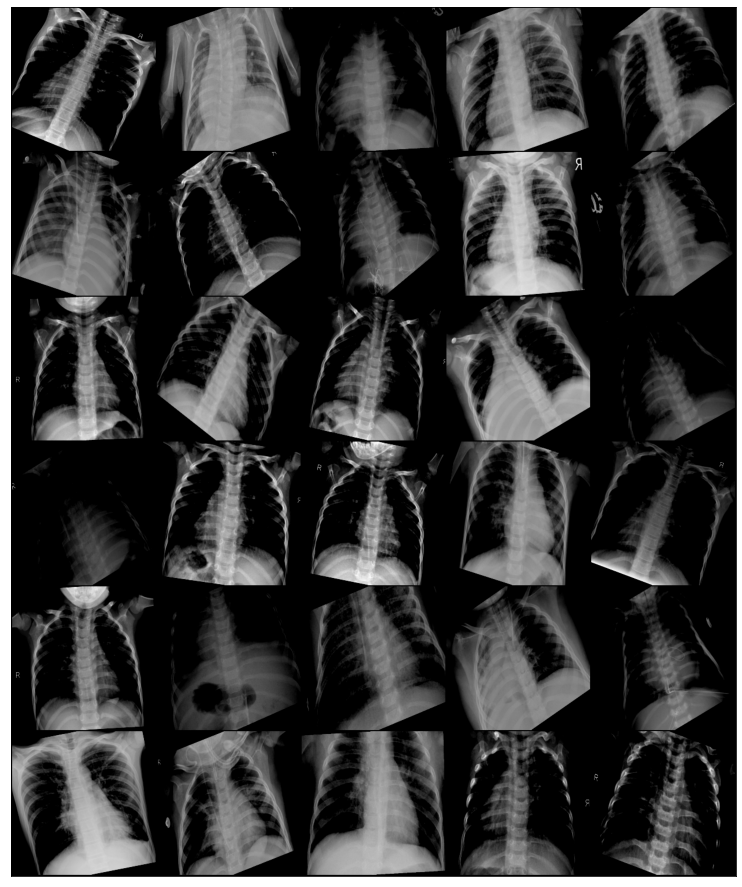

In [21]:
show_images(train_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


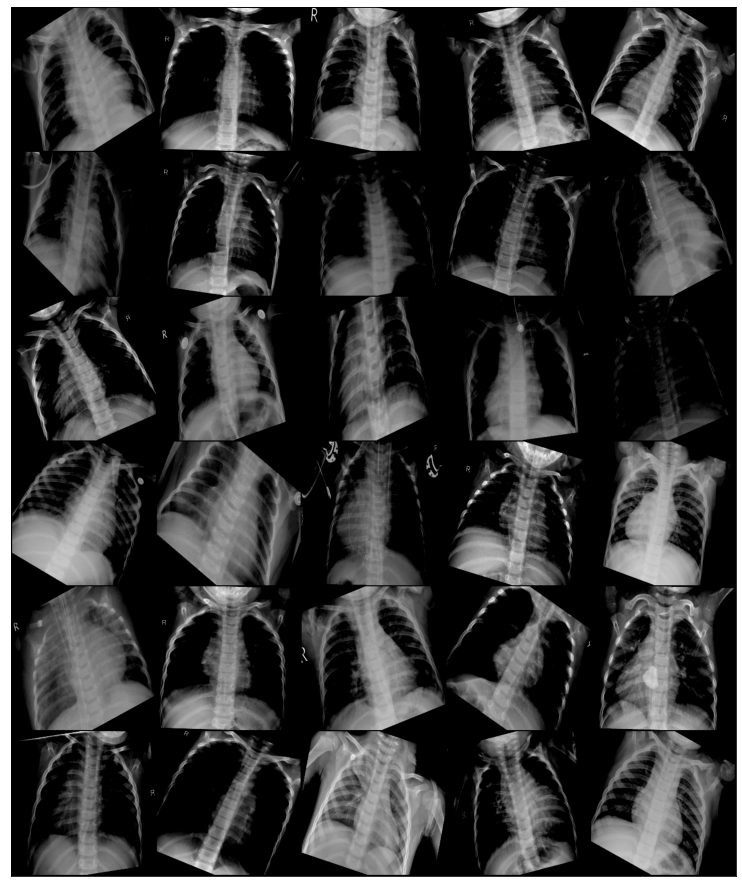

In [22]:
show_images(valid_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


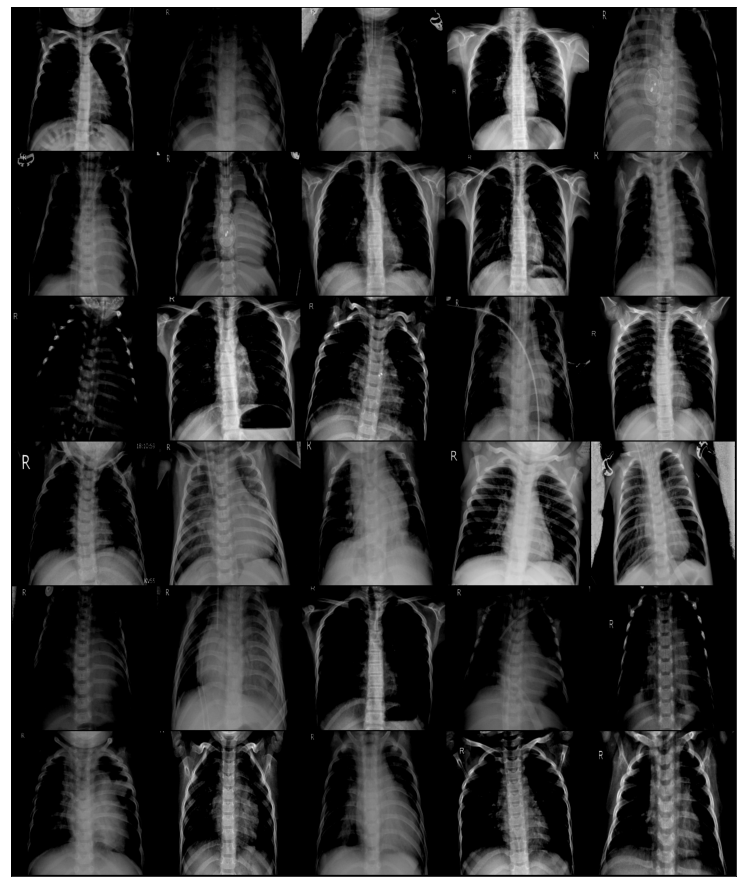

In [23]:
show_images(test_loader)

# Building the model

In [24]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 3, padding = 1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
        self.conv4 = nn.Conv2d(64, 128, 3, padding = 1)
        self.conv5 = nn.Conv2d(128, 256, 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)
        self.bn5 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 8 * 8, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 2)
        self.dropout = nn.Dropout(0.6)

    def forward(self, x):
        
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        
        
        x = x.view(-1, 256 * 8 * 8)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

We have trained this model twice - with 2 different optimisers:


*   Adam
*   SGD with Nesterov accelaration

These are known to produce the best results in image classification problems. The training given below has been done on Adam. To use SGD with Nesterov accelaration instead, use the commented out optimizer instead of the one used below.









In [25]:
# specifying the loss function (categorical cross-entropy)

model = ConvNet()
criterion = nn.CrossEntropyLoss()

# specifying optimizer

optimizer = optim.Adam(model.parameters(), lr = 0.008, weight_decay = 0.02)
# optimizer = optim.SGD(model.parameters(), lr = 0.008,momentum = 0.9, nesterov = True)

# specifying scheduler

scheduler = optim.lr_scheduler.ExponentialLR(optimizer,gamma = 0.2)

if train_on_gpu:
    model.cuda()

print(model)

ConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=1024, bias=True)
  (fc2)

In [26]:
pwd

'/home/sysadm/Documents/3ml_kkm/env'


# Training and validating the model


In [27]:
# number of epochs to train the model
n_epochs = 100

valid_loss_min = np.Inf # track change in validation loss
train_losses, valid_losses = [], []
train_acc, valid_acc = [], []
for epoch in tqdm(range(1, n_epochs+1), desc = "Train Model/Epoch: "):

    # keeping track of loss and accuracy
    train_loss = 0.0
    valid_loss = 0.0
    train_accuracy = 0.0
    valid_accuracy = 0.0

    ######################
    # training the model #
    ######################
    model.train()
    for data, target in tqdm(train_loader, desc = 'Model Train: '):
        # moving tensors to GPU if CUDA is available
        data = torch.Tensor(data)
        target = tuple([0 if i=='NORMAL' else 1 for i in list(target)])
        target = torch.Tensor(np.array(target))
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clearing the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        target = target.long()
        # calculating the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # performing a single optimization step (parameter update)
        optimizer.step()
        # updating training loss
        train_loss += loss.item()*data.size(0)
        # updating training accuracy
        train_accuracy += accuracy(output,target)
        
    scheduler.step() # decay LR

    ########################  
    # validating the model #
    ########################
    model.eval()
    for data, target in tqdm(valid_loader, desc = 'Model validation: '):
        # moving tensors to GPU if CUDA is available
        data = torch.Tensor(data)
        target = tuple([0 if i=='NORMAL' else 1 for i in list(target)])
        target = torch.Tensor(np.array(target))
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        target = target.long()
        # calculating the batch loss
        loss = criterion(output, target)
        # updating average validation loss 
        valid_loss += loss.item()*data.size(0)
        # updating validation accuracy
        valid_accuracy += accuracy(output,target)
    
    # calculating average losses
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)

    # calculating average accuracy
    train_accuracy = train_accuracy/len(train_loader)
    valid_accuracy = valid_accuracy/len(valid_loader)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_acc.append(train_accuracy)
    valid_acc.append(valid_accuracy)
      
    # printing training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \n\t\tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch, train_loss, valid_loss, train_accuracy, valid_accuracy))
    
    # saving model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), './../models/model_pneumonia.pt')
        valid_loss_min = valid_loss


Epoch: 1 	Training Loss: 78.118760 	Validation Loss: 19.025634 
		Training Accuracy: 0.758929 	Validation Accuracy: 0.745201
Validation loss decreased (inf --> 19.025634).  Saving model ...



Epoch: 2 	Training Loss: 8.630891 	Validation Loss: 11.952998 
		Training Accuracy: 0.875149 	Validation Accuracy: 0.812454
Validation loss decreased (19.025634 --> 11.952998).  Saving model ...



Epoch: 3 	Training Loss: 6.160637 	Validation Loss: 5.480922 
		Training Accuracy: 0.921905 	Validation Accuracy: 0.919560
Validation loss decreased (11.952998 --> 5.480922).  Saving model ...



Epoch: 4 	Training Loss: 5.133198 	Validation Loss: 4.369609 
		Training Accuracy: 0.936459 	Validation Accuracy: 0.944615
Validation loss decreased (5.480922 --> 4.369609).  Saving model ...



Epoch: 5 	Training Loss: 4.771325 	Validation Loss: 4.146960 
		Training Accuracy: 0.941727 	Validation Accuracy: 0.947985
Validation loss decreased (4.369609 --> 4.146960).  Saving model ...



Epoch: 6 	Training Loss: 4.468520 	Validation Loss: 4.065775 
		Training Accuracy: 0.945477 	Validation Accuracy: 0.954286
Validation loss decreased (4.146960 --> 4.065775).  Saving model ...



Epoch: 7 	Training Loss: 4.318840 	Validation Loss: 4.137589 
		Training Accuracy: 0.947917 	Validation Accuracy: 0.949377



Epoch: 8 	Training Loss: 4.236315 	Validation Loss: 4.223764 
		Training Accuracy: 0.949762 	Validation Accuracy: 0.943809



Epoch: 9 	Training Loss: 4.423145 	Validation Loss: 4.090816 
		Training Accuracy: 0.946459 	Validation Accuracy: 0.943810



Epoch: 10 	Training Loss: 4.370817 	Validation Loss: 4.102598 
		Training Accuracy: 0.947857 	Validation Accuracy: 0.950330



Epoch: 11 	Training Loss: 4.425606 	Validation Loss: 4.342477 
		Training Accuracy: 0.942441 	Validation Accuracy: 0.943516



Epoch: 12 	Training Loss: 4.373963 	Validation Loss: 4.197989 
		Training Accuracy: 0.947143 	Validation Accuracy: 0.946374



Epoch: 13 	Training Loss: 4.505095 	Validation Loss: 3.972159 
		Training Accuracy: 0.947917 	Validation Accuracy: 0.946667
Validation loss decreased (4.065775 --> 3.972159).  Saving model ...



Epoch: 14 	Training Loss: 4.450557 	Validation Loss: 4.139354 
		Training Accuracy: 0.947173 	Validation Accuracy: 0.945421



Epoch: 15 	Training Loss: 4.492465 	Validation Loss: 4.199612 
		Training Accuracy: 0.947143 	Validation Accuracy: 0.941465



Epoch: 16 	Training Loss: 4.328222 	Validation Loss: 4.019412 
		Training Accuracy: 0.949078 	Validation Accuracy: 0.947473



Epoch: 17 	Training Loss: 4.180741 	Validation Loss: 4.101105 
		Training Accuracy: 0.951221 	Validation Accuracy: 0.943223



Epoch: 18 	Training Loss: 4.424772 	Validation Loss: 4.231482 
		Training Accuracy: 0.945477 	Validation Accuracy: 0.945714



Epoch: 19 	Training Loss: 4.411623 	Validation Loss: 4.089917 
		Training Accuracy: 0.947679 	Validation Accuracy: 0.949524



Epoch: 20 	Training Loss: 4.331415 	Validation Loss: 4.165735 
		Training Accuracy: 0.945238 	Validation Accuracy: 0.945421



Epoch: 21 	Training Loss: 4.366600 	Validation Loss: 3.887424 
		Training Accuracy: 0.949078 	Validation Accuracy: 0.947473
Validation loss decreased (3.972159 --> 3.887424).  Saving model ...



Epoch: 22 	Training Loss: 4.308535 	Validation Loss: 4.079916 
		Training Accuracy: 0.950536 	Validation Accuracy: 0.950330



Epoch: 23 	Training Loss: 4.471057 	Validation Loss: 4.255373 
		Training Accuracy: 0.945982 	Validation Accuracy: 0.944469



Epoch: 24 	Training Loss: 4.319843 	Validation Loss: 4.162312 
		Training Accuracy: 0.947857 	Validation Accuracy: 0.945568



Epoch: 25 	Training Loss: 4.445450 	Validation Loss: 3.934991 
		Training Accuracy: 0.948602 	Validation Accuracy: 0.951428



Epoch: 26 	Training Loss: 4.202756 	Validation Loss: 4.202244 
		Training Accuracy: 0.951488 	Validation Accuracy: 0.944176



Epoch: 27 	Training Loss: 4.362491 	Validation Loss: 3.983603 
		Training Accuracy: 0.947411 	Validation Accuracy: 0.952235



Epoch: 28 	Training Loss: 4.465144 	Validation Loss: 4.075760 
		Training Accuracy: 0.947173 	Validation Accuracy: 0.944615



Epoch: 29 	Training Loss: 4.260040 	Validation Loss: 4.003717 
		Training Accuracy: 0.951667 	Validation Accuracy: 0.951135



Epoch: 30 	Training Loss: 4.308027 	Validation Loss: 3.967594 
		Training Accuracy: 0.949524 	Validation Accuracy: 0.949524



Epoch: 31 	Training Loss: 4.412467 	Validation Loss: 4.120583 
		Training Accuracy: 0.950238 	Validation Accuracy: 0.945568



Epoch: 32 	Training Loss: 4.306862 	Validation Loss: 4.055112 
		Training Accuracy: 0.944286 	Validation Accuracy: 0.943663



Epoch: 33 	Training Loss: 4.203272 	Validation Loss: 3.992813 
		Training Accuracy: 0.954286 	Validation Accuracy: 0.952234



Epoch: 34 	Training Loss: 4.476393 	Validation Loss: 4.119056 
		Training Accuracy: 0.947381 	Validation Accuracy: 0.949084



Epoch: 35 	Training Loss: 4.403752 	Validation Loss: 4.100907 
		Training Accuracy: 0.945000 	Validation Accuracy: 0.948278



Epoch: 36 	Training Loss: 4.105152 	Validation Loss: 4.132325 
		Training Accuracy: 0.954554 	Validation Accuracy: 0.945568



Epoch: 37 	Training Loss: 4.297418 	Validation Loss: 4.272868 
		Training Accuracy: 0.947411 	Validation Accuracy: 0.940806



Epoch: 38 	Training Loss: 4.441558 	Validation Loss: 3.982885 
		Training Accuracy: 0.949792 	Validation Accuracy: 0.949231



Epoch: 39 	Training Loss: 4.327732 	Validation Loss: 4.004139 
		Training Accuracy: 0.952857 	Validation Accuracy: 0.946667



Epoch: 40 	Training Loss: 4.248325 	Validation Loss: 3.877483 
		Training Accuracy: 0.950268 	Validation Accuracy: 0.947326
Validation loss decreased (3.887424 --> 3.877483).  Saving model ...



Epoch: 41 	Training Loss: 4.471760 	Validation Loss: 4.095389 
		Training Accuracy: 0.946727 	Validation Accuracy: 0.948571



Epoch: 42 	Training Loss: 4.514648 	Validation Loss: 3.955327 
		Training Accuracy: 0.946191 	Validation Accuracy: 0.944615



Epoch: 43 	Training Loss: 4.235168 	Validation Loss: 3.982700 
		Training Accuracy: 0.948602 	Validation Accuracy: 0.951282



Epoch: 44 	Training Loss: 4.467456 	Validation Loss: 4.040695 
		Training Accuracy: 0.946459 	Validation Accuracy: 0.949377



Epoch: 45 	Training Loss: 4.323918 	Validation Loss: 3.881235 
		Training Accuracy: 0.950477 	Validation Accuracy: 0.950330



Epoch: 46 	Training Loss: 4.229419 	Validation Loss: 4.030615 
		Training Accuracy: 0.949078 	Validation Accuracy: 0.952381



Epoch: 47 	Training Loss: 4.589242 	Validation Loss: 4.148905 
		Training Accuracy: 0.945745 	Validation Accuracy: 0.940952



Epoch: 48 	Training Loss: 4.355665 	Validation Loss: 4.057556 
		Training Accuracy: 0.946459 	Validation Accuracy: 0.946227



Epoch: 49 	Training Loss: 4.616849 	Validation Loss: 4.143768 
		Training Accuracy: 0.945268 	Validation Accuracy: 0.941758



Epoch: 50 	Training Loss: 4.157274 	Validation Loss: 4.051403 
		Training Accuracy: 0.948155 	Validation Accuracy: 0.948425



Epoch: 51 	Training Loss: 4.330820 	Validation Loss: 3.976135 
		Training Accuracy: 0.946727 	Validation Accuracy: 0.943663



Epoch: 52 	Training Loss: 4.509131 	Validation Loss: 4.210720 
		Training Accuracy: 0.947441 	Validation Accuracy: 0.940806



Epoch: 53 	Training Loss: 4.363433 	Validation Loss: 4.085523 
		Training Accuracy: 0.946310 	Validation Accuracy: 0.942711



Epoch: 54 	Training Loss: 4.329374 	Validation Loss: 4.128520 
		Training Accuracy: 0.946756 	Validation Accuracy: 0.946520



Epoch: 55 	Training Loss: 4.400236 	Validation Loss: 3.954015 
		Training Accuracy: 0.949048 	Validation Accuracy: 0.952088



Epoch: 56 	Training Loss: 4.504717 	Validation Loss: 4.235549 
		Training Accuracy: 0.948572 	Validation Accuracy: 0.946080



Epoch: 57 	Training Loss: 4.463024 	Validation Loss: 3.948046 
		Training Accuracy: 0.943125 	Validation Accuracy: 0.947619



Epoch: 58 	Training Loss: 4.398079 	Validation Loss: 3.897638 
		Training Accuracy: 0.946667 	Validation Accuracy: 0.948278



Epoch: 59 	Training Loss: 4.376378 	Validation Loss: 4.081883 
		Training Accuracy: 0.949078 	Validation Accuracy: 0.945421



Epoch: 60 	Training Loss: 4.291211 	Validation Loss: 4.113515 
		Training Accuracy: 0.949048 	Validation Accuracy: 0.949524



Epoch: 61 	Training Loss: 4.572069 	Validation Loss: 4.129477 
		Training Accuracy: 0.946429 	Validation Accuracy: 0.949377



Epoch: 62 	Training Loss: 4.531359 	Validation Loss: 4.047833 
		Training Accuracy: 0.946191 	Validation Accuracy: 0.949377



Epoch: 63 	Training Loss: 4.382372 	Validation Loss: 4.225421 
		Training Accuracy: 0.947709 	Validation Accuracy: 0.942711



Epoch: 64 	Training Loss: 4.147504 	Validation Loss: 4.304519 
		Training Accuracy: 0.947203 	Validation Accuracy: 0.941905



Epoch: 65 	Training Loss: 4.354286 	Validation Loss: 4.034191 
		Training Accuracy: 0.949792 	Validation Accuracy: 0.952234



Epoch: 66 	Training Loss: 4.615275 	Validation Loss: 4.292393 
		Training Accuracy: 0.944762 	Validation Accuracy: 0.944469



Epoch: 67 	Training Loss: 4.416802 	Validation Loss: 4.154194 
		Training Accuracy: 0.947203 	Validation Accuracy: 0.947473



Epoch: 68 	Training Loss: 4.463829 	Validation Loss: 4.224046 
		Training Accuracy: 0.949048 	Validation Accuracy: 0.943809



Epoch: 69 	Training Loss: 4.397315 	Validation Loss: 3.923909 
		Training Accuracy: 0.947887 	Validation Accuracy: 0.949084



Epoch: 70 	Training Loss: 4.449658 	Validation Loss: 3.949501 
		Training Accuracy: 0.947381 	Validation Accuracy: 0.947473



Epoch: 71 	Training Loss: 4.487672 	Validation Loss: 3.959450 
		Training Accuracy: 0.947858 	Validation Accuracy: 0.950330



Epoch: 72 	Training Loss: 4.458922 	Validation Loss: 4.124105 
		Training Accuracy: 0.944792 	Validation Accuracy: 0.949230



Epoch: 73 	Training Loss: 4.467346 	Validation Loss: 4.053494 
		Training Accuracy: 0.950268 	Validation Accuracy: 0.951282



Epoch: 74 	Training Loss: 4.438444 	Validation Loss: 4.088782 
		Training Accuracy: 0.945774 	Validation Accuracy: 0.949524



Epoch: 75 	Training Loss: 4.458971 	Validation Loss: 4.138270 
		Training Accuracy: 0.947381 	Validation Accuracy: 0.950183



Epoch: 76 	Training Loss: 4.280409 	Validation Loss: 4.181010 
		Training Accuracy: 0.949316 	Validation Accuracy: 0.945714



Epoch: 77 	Training Loss: 4.537152 	Validation Loss: 4.025983 
		Training Accuracy: 0.948572 	Validation Accuracy: 0.948938



Epoch: 78 	Training Loss: 4.424292 	Validation Loss: 4.012586 
		Training Accuracy: 0.946221 	Validation Accuracy: 0.956190



Epoch: 79 	Training Loss: 4.596270 	Validation Loss: 4.072958 
		Training Accuracy: 0.950268 	Validation Accuracy: 0.943809



Epoch: 80 	Training Loss: 4.437507 	Validation Loss: 3.956301 
		Training Accuracy: 0.948602 	Validation Accuracy: 0.949377



Epoch: 81 	Training Loss: 4.719672 	Validation Loss: 4.221606 
		Training Accuracy: 0.941905 	Validation Accuracy: 0.945275



Epoch: 82 	Training Loss: 4.453207 	Validation Loss: 4.037356 
		Training Accuracy: 0.946697 	Validation Accuracy: 0.941905



Epoch: 83 	Training Loss: 4.319076 	Validation Loss: 4.163154 
		Training Accuracy: 0.950477 	Validation Accuracy: 0.945714



Epoch: 84 	Training Loss: 4.506349 	Validation Loss: 4.076897 
		Training Accuracy: 0.946459 	Validation Accuracy: 0.941758



Epoch: 85 	Training Loss: 4.561115 	Validation Loss: 4.265839 
		Training Accuracy: 0.944792 	Validation Accuracy: 0.944762



Epoch: 86 	Training Loss: 4.459120 	Validation Loss: 4.360689 
		Training Accuracy: 0.949286 	Validation Accuracy: 0.945568



Epoch: 87 	Training Loss: 4.599127 	Validation Loss: 4.161524 
		Training Accuracy: 0.946727 	Validation Accuracy: 0.946373



Epoch: 88 	Training Loss: 4.443397 	Validation Loss: 4.160495 
		Training Accuracy: 0.945834 	Validation Accuracy: 0.947473



Epoch: 89 	Training Loss: 4.776461 	Validation Loss: 3.965901 
		Training Accuracy: 0.945477 	Validation Accuracy: 0.946374



Epoch: 90 	Training Loss: 4.400144 	Validation Loss: 4.052342 
		Training Accuracy: 0.945477 	Validation Accuracy: 0.946667



Epoch: 91 	Training Loss: 4.218872 	Validation Loss: 4.026609 
		Training Accuracy: 0.950268 	Validation Accuracy: 0.948571



Epoch: 92 	Training Loss: 4.606010 	Validation Loss: 3.898826 
		Training Accuracy: 0.945477 	Validation Accuracy: 0.948571



Epoch: 93 	Training Loss: 4.566362 	Validation Loss: 4.057926 
		Training Accuracy: 0.945030 	Validation Accuracy: 0.946374



Epoch: 94 	Training Loss: 4.396929 	Validation Loss: 4.165209 
		Training Accuracy: 0.948572 	Validation Accuracy: 0.947472



Epoch: 95 	Training Loss: 4.440193 	Validation Loss: 4.040040 
		Training Accuracy: 0.948572 	Validation Accuracy: 0.953333



Epoch: 96 	Training Loss: 4.378953 	Validation Loss: 3.938155 
		Training Accuracy: 0.945774 	Validation Accuracy: 0.946520



Epoch: 97 	Training Loss: 4.351010 	Validation Loss: 4.056520 
		Training Accuracy: 0.948572 	Validation Accuracy: 0.943516



Epoch: 98 	Training Loss: 4.803754 	Validation Loss: 4.003698 
		Training Accuracy: 0.943810 	Validation Accuracy: 0.950476



Epoch: 99 	Training Loss: 4.442692 	Validation Loss: 4.072057 
		Training Accuracy: 0.947649 	Validation Accuracy: 0.947179



Epoch: 100 	Training Loss: 4.184012 	Validation Loss: 4.058261 
		Training Accuracy: 0.949108 	Validation Accuracy: 0.950330



# Plotting training/validation losses

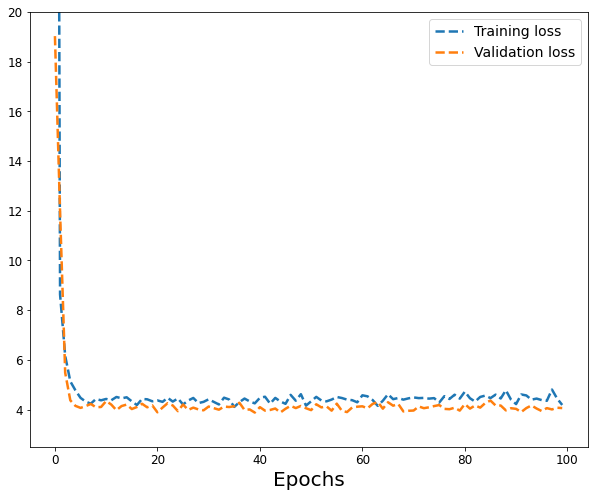

In [28]:

plt.figure(figsize=(10,8))
plt.plot(train_losses,'--',linewidth = 2.5, label='Training loss')
plt.plot(valid_losses,'--', linewidth = 2.5, label='Validation loss')
plt.xlabel('Epochs',fontsize = 20)
plt.ylim(2.5,20)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12);

# Plotting training/validation accuracy

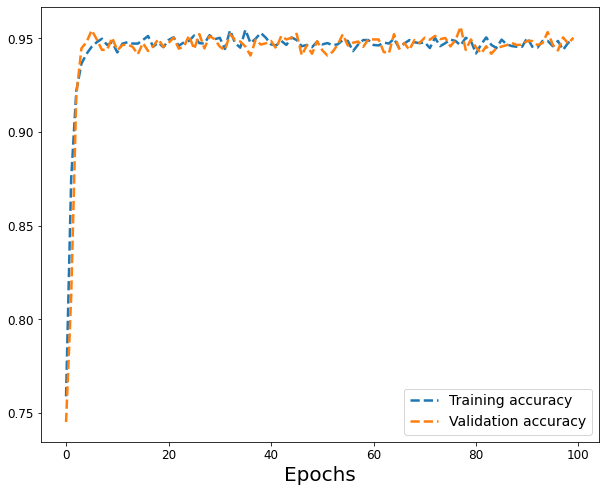

In [29]:
plt.figure(figsize=(10,8))
plt.plot(train_acc,'--', linewidth = 2.5, label='Training accuracy')
plt.plot(valid_acc,'--', linewidth = 2.5, label='Validation accuracy')
plt.xlabel('Epochs', fontsize = 20)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12);

# Loading model with lowest validation loss

In [30]:
pwd

'/home/sysadm/Documents/3ml_kkm/env'

In [31]:
model.load_state_dict(torch.load('./../models/model_pneumonia.pt'))

<All keys matched successfully>

# Testing the model

In [32]:
# tracking test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
# iterating over test data
for data, target in tqdm(test_loader, desc = 'Model Test: '):
    # moving tensors to GPU if CUDA is available
    data = torch.Tensor(data)
    target = tuple([0 if i=='NORMAL' else 1 for i in list(target)])
    target = torch.Tensor(np.array(target))
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: computing predicted outputs by passing inputs to the model
    output = model(data)
    target = target.long()
    # calculating the batch loss
    loss = criterion(output, target)
    # updating test loss 
    test_loss += loss.item()*data.size(0)
    # converting output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # comparing predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculating test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.445040

Test Accuracy of PNEUMONIA: 61% (143/234)
Test Accuracy of NORMAL: 96% (377/390)

Test Accuracy (Overall): 83% (520/624)


# Evaulating the model

In [33]:
confusion_matrix = torch.zeros(2,2)
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        data = torch.Tensor(data)
        target = tuple([0 if i=='NORMAL' else 1 for i in list(target)])
        target = torch.Tensor(np.array(target))
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            target = target.long()
            _, preds = torch.max(output, 1)
        for t, p in zip(target.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[143.,  91.],
        [ 13., 377.]])


In [34]:
cm = confusion_matrix.numpy()
tn, fp, fn, tp = cm.ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1_score = (2*precision*recall)/(precision+recall)
print("Precision: {:.4f}\nRecall: {:.4f}\nF1 Score: {:.4f}".format(precision,recall,f1_score))

Precision: 0.8056
Recall: 0.9667
F1 Score: 0.8788


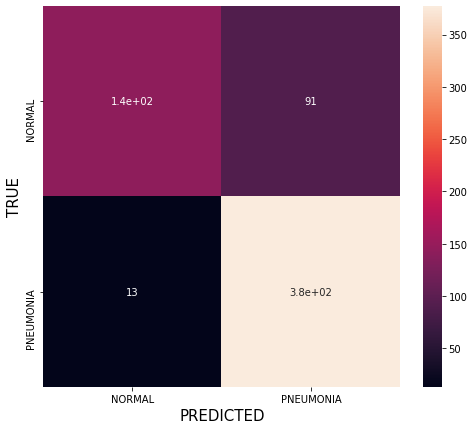

In [35]:
plt.figure(figsize=(8,7))
xticks = np.array(['NORMAL','PNEUMONIA'])
sns.heatmap(cm, annot = True, 
            xticklabels = xticks, yticklabels = xticks)
plt.xlabel('PREDICTED',fontsize = 15)
plt.ylabel('TRUE',fontsize = 15);

# Visualising predicted results 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


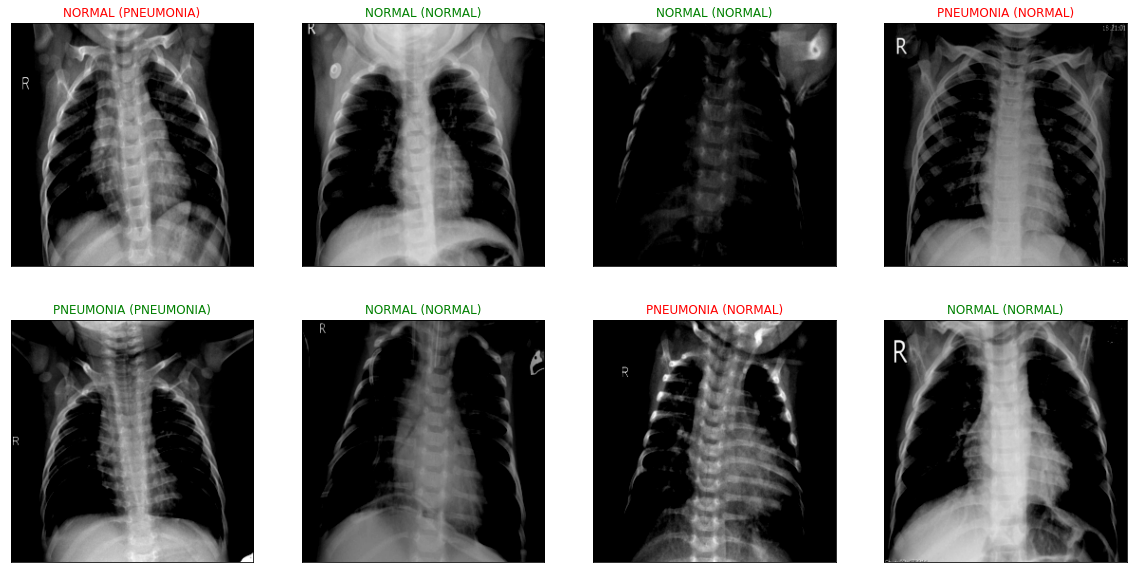

In [36]:
# obtaining one batch of test images
data, target = next(iter(test_loader))
data.numpy()

# moving model inputs to cuda, if GPU available
if train_on_gpu:
    data = data.cuda()

# getting sample outputs
output = model(data)

# converting output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
target = tuple([0 if i=='NORMAL' else 1 for i in list(target)])

# plotting the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(20,10))
for idx in np.arange(8):
    ax = fig.add_subplot(2,4, idx+1, xticks=[], yticks=[])
    ax.imshow(data[idx].permute(1, 2, 0) if not train_on_gpu else data[idx].cpu().permute(1, 2, 0))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[target[idx]]),
                 color=("green" if preds[idx]==target[idx] else "red"))

# Using Transfer Learning

##ResNet50 backbone

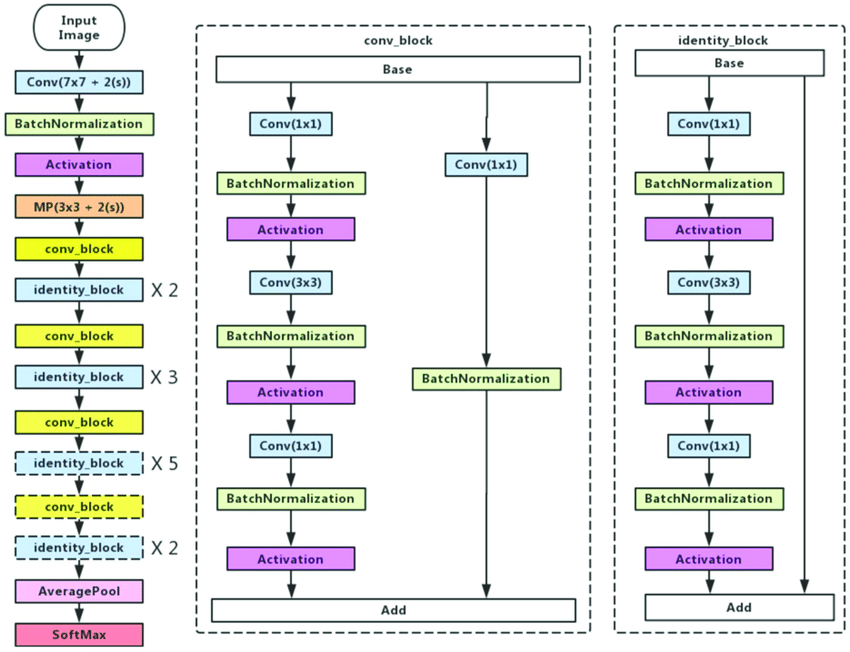

## Defining transformations according to ResNet50 standards

In [37]:
train_transforms_res = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize((224,224)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
                                       ]) 

test_transforms_res = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
                                      ])

In [38]:
train_data_res = datasets.ImageFolder(train_dir, transform = train_transforms_res)
test_data_res = datasets.ImageFolder(test_dir, transform = test_transforms_res)

# Splitting training data into training and validation sets

In [39]:
# training indices to be used for validation

num_train_res = len(train_data_res); print(num_train_res)
indices = list(range(num_train_res))
np.random.shuffle(indices)
split = int(np.floor(0.2 * num_train_res)); print(split)
train_idx, valid_idx = indices[split:], indices[:split] 

5232
1046


In [40]:
# defining samplers for obtaining training and validation batches

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [41]:
# loading the data 

train_loader = torch.utils.data.DataLoader(train_data_res, batch_size = 30, sampler = train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data_res, batch_size = 30, sampler = valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data_res, batch_size = 30, shuffle = True)
next(iter(test_loader))

[tensor([[[[-0.9534, -0.9020, -0.8678,  ..., -1.3644, -1.3815, -1.4500],
           [-0.9020, -0.9020, -0.8849,  ..., -1.3473, -1.3815, -1.4500],
           [-0.9192, -0.9192, -0.9020,  ..., -1.3302, -1.3815, -1.4500],
           ...,
           [-1.7412, -1.7412, -1.7583,  ..., -1.7583, -1.7754, -1.7583],
           [-1.7412, -1.7412, -1.7583,  ..., -1.7583, -1.7754, -1.7925],
           [-1.7412, -1.7412, -1.7583,  ..., -1.7412, -1.7583, -1.7925]],
 
          [[-0.8452, -0.7927, -0.7577,  ..., -1.2654, -1.2829, -1.3529],
           [-0.7927, -0.7927, -0.7752,  ..., -1.2479, -1.2829, -1.3529],
           [-0.8102, -0.8102, -0.7927,  ..., -1.2304, -1.2829, -1.3529],
           ...,
           [-1.6506, -1.6506, -1.6681,  ..., -1.6681, -1.6856, -1.6681],
           [-1.6506, -1.6506, -1.6681,  ..., -1.6681, -1.6856, -1.7031],
           [-1.6506, -1.6506, -1.6681,  ..., -1.6506, -1.6681, -1.7031]],
 
          [[-0.6193, -0.5670, -0.5321,  ..., -1.0376, -1.0550, -1.1247],
           [-

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


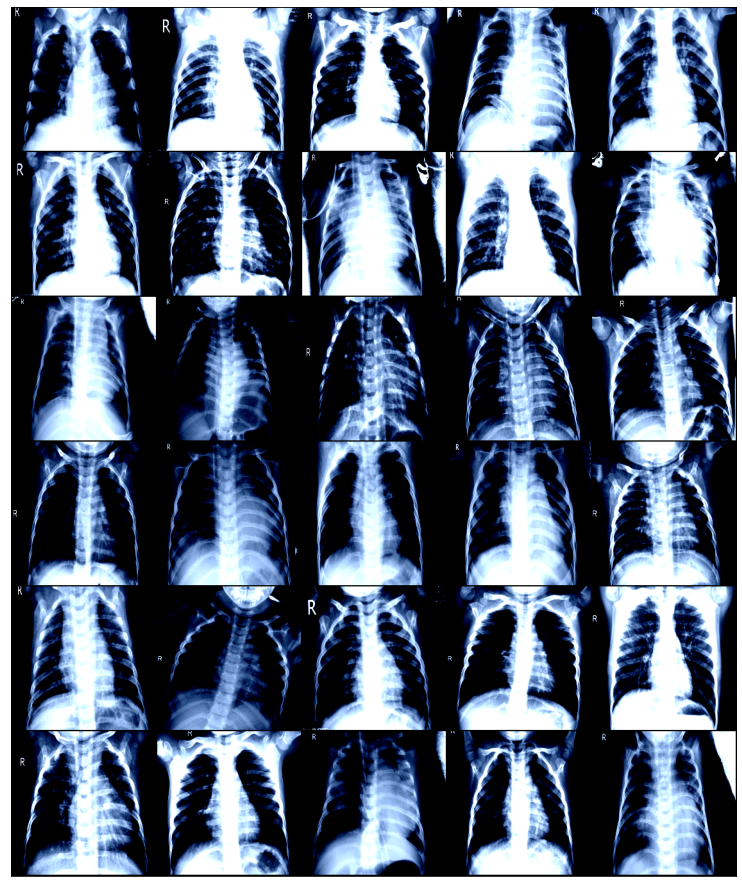

In [42]:
show_images(test_loader)

# Loading pretrained ResNet50 model and adding final layers

In [43]:
res_model = models.resnet50(pretrained=True)
print(res_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [44]:
# Freezing training for all "features" layers
for param in res_model.parameters():
    param.requires_grad = False

In [45]:
# Adding final layers
res_model.fc = nn.Sequential(nn.Linear(2048,512),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.Dropout(0.4),
                         nn.Linear(512,2),
                         nn.LogSoftmax(dim=1)) 

In [46]:
# specifying the loss function (categorical cross-entropy)

criterion = nn.CrossEntropyLoss()

# specifying optimizer

optimizer = optim.SGD(res_model.parameters(), lr = 0.008,momentum = 0.9, nesterov = True)

# specifying scheduler

scheduler = optim.lr_scheduler.ExponentialLR(optimizer,gamma = 0.2)

if train_on_gpu:
    res_model.cuda()

print(res_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 


# Training and validating the model


In [47]:
# number of epochs to train the model
n_epochs = 100

valid_loss_min = np.Inf # track change in validation loss
train_losses, valid_losses = [], []
train_acc, valid_acc = [], []
for epoch in tqdm(range(1, n_epochs+1), desc = 'Model Train/Epoch: '):

    # keeping track of loss and accuracy
    train_loss = 0.0
    valid_loss = 0.0
    train_accuracy = 0.0
    valid_accuracy = 0.0

    ######################
    # training the model #
    ######################
    res_model.train()
    for data, target in tqdm(train_loader, desc = 'Model Train: '):
        # moving tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clearing the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: computing predicted outputs by passing inputs to the model
        output = res_model(data)
        target = target.long()
        # calculating the batch loss
        loss = criterion(output, target)
        # backward pass: computing gradient of the loss with respect to model parameters
        loss.backward()
        # performing a single optimization step (parameter update)
        optimizer.step()
        # updating training loss
        train_loss += loss.item()*data.size(0)
        # updating training accuracy
        train_accuracy += accuracy(output,target)
        
    scheduler.step() # decay LR

    ########################  
    # validating the model #
    ########################
    res_model.eval()
    for data, target in tqdm(valid_loader, desc = 'Model Validation: '):
        # moving tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: computing predicted outputs by passing inputs to the model
        output = res_model(data)
        target = target.long()
        # calculating the batch loss
        loss = criterion(output, target)
        # updating average validation loss 
        valid_loss += loss.item()*data.size(0)
        # updating validation accuracy
        valid_accuracy += accuracy(output,target)
    
    # calculating average losses
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)

    # calculating average accuracy
    train_accuracy = train_accuracy/len(train_loader)
    valid_accuracy = valid_accuracy/len(valid_loader)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_acc.append(train_accuracy)
    valid_acc.append(valid_accuracy)
      
    # printing training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \n\t\tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch, train_loss, valid_loss, train_accuracy, valid_accuracy))
    
    # saving model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(res_model.state_dict(), './../models/res_model_pneumonia.pt')
        valid_loss_min = valid_loss


Epoch: 1 	Training Loss: 5.319068 	Validation Loss: 5.963136 
		Training Accuracy: 0.927411 	Validation Accuracy: 0.925714
Validation loss decreased (inf --> 5.963136).  Saving model ...



Epoch: 2 	Training Loss: 4.056168 	Validation Loss: 2.948793 
		Training Accuracy: 0.947381 	Validation Accuracy: 0.960659
Validation loss decreased (5.963136 --> 2.948793).  Saving model ...



Epoch: 3 	Training Loss: 3.806745 	Validation Loss: 3.142063 
		Training Accuracy: 0.950000 	Validation Accuracy: 0.965568



Epoch: 4 	Training Loss: 3.629755 	Validation Loss: 2.770528 
		Training Accuracy: 0.952679 	Validation Accuracy: 0.969231
Validation loss decreased (2.948793 --> 2.770528).  Saving model ...



Epoch: 5 	Training Loss: 3.652192 	Validation Loss: 2.991458 
		Training Accuracy: 0.952173 	Validation Accuracy: 0.962857



Epoch: 6 	Training Loss: 3.432711 	Validation Loss: 3.251117 
		Training Accuracy: 0.955476 	Validation Accuracy: 0.958901



Epoch: 7 	Training Loss: 3.550301 	Validation Loss: 3.362435 
		Training Accuracy: 0.953185 	Validation Accuracy: 0.952088



Epoch: 8 	Training Loss: 3.720683 	Validation Loss: 2.979840 
		Training Accuracy: 0.954286 	Validation Accuracy: 0.959048



Epoch: 9 	Training Loss: 3.465660 	Validation Loss: 2.911785 
		Training Accuracy: 0.954137 	Validation Accuracy: 0.959048



Epoch: 10 	Training Loss: 3.606291 	Validation Loss: 2.476047 
		Training Accuracy: 0.955030 	Validation Accuracy: 0.971282
Validation loss decreased (2.770528 --> 2.476047).  Saving model ...



Epoch: 11 	Training Loss: 3.558153 	Validation Loss: 2.724567 
		Training Accuracy: 0.954316 	Validation Accuracy: 0.965568



Epoch: 12 	Training Loss: 3.636773 	Validation Loss: 3.364319 
		Training Accuracy: 0.955000 	Validation Accuracy: 0.957949



Epoch: 13 	Training Loss: 3.504733 	Validation Loss: 3.120922 
		Training Accuracy: 0.952143 	Validation Accuracy: 0.959707



Epoch: 14 	Training Loss: 3.436907 	Validation Loss: 2.781393 
		Training Accuracy: 0.952441 	Validation Accuracy: 0.965568



Epoch: 15 	Training Loss: 3.467195 	Validation Loss: 3.190658 
		Training Accuracy: 0.955566 	Validation Accuracy: 0.958095



Epoch: 16 	Training Loss: 3.561147 	Validation Loss: 2.710242 
		Training Accuracy: 0.953096 	Validation Accuracy: 0.967180



Epoch: 17 	Training Loss: 3.394059 	Validation Loss: 3.083567 
		Training Accuracy: 0.954792 	Validation Accuracy: 0.967619



Epoch: 18 	Training Loss: 3.545196 	Validation Loss: 3.295047 
		Training Accuracy: 0.954554 	Validation Accuracy: 0.959048



Epoch: 19 	Training Loss: 3.483320 	Validation Loss: 3.160184 
		Training Accuracy: 0.954048 	Validation Accuracy: 0.959560



Epoch: 20 	Training Loss: 3.753543 	Validation Loss: 2.983220 
		Training Accuracy: 0.952858 	Validation Accuracy: 0.968571



Epoch: 21 	Training Loss: 3.796485 	Validation Loss: 2.773243 
		Training Accuracy: 0.953572 	Validation Accuracy: 0.963663



Epoch: 22 	Training Loss: 3.456433 	Validation Loss: 2.622279 
		Training Accuracy: 0.955000 	Validation Accuracy: 0.969231



Epoch: 23 	Training Loss: 3.569574 	Validation Loss: 2.905816 
		Training Accuracy: 0.953334 	Validation Accuracy: 0.962857



Epoch: 24 	Training Loss: 3.689424 	Validation Loss: 2.975902 
		Training Accuracy: 0.951697 	Validation Accuracy: 0.965568



Epoch: 25 	Training Loss: 3.845975 	Validation Loss: 2.783165 
		Training Accuracy: 0.951905 	Validation Accuracy: 0.966520



Epoch: 26 	Training Loss: 3.527705 	Validation Loss: 2.981219 
		Training Accuracy: 0.951727 	Validation Accuracy: 0.961905



Epoch: 27 	Training Loss: 3.453213 	Validation Loss: 2.799123 
		Training Accuracy: 0.955238 	Validation Accuracy: 0.964762



Epoch: 28 	Training Loss: 3.593889 	Validation Loss: 2.795605 
		Training Accuracy: 0.954762 	Validation Accuracy: 0.966227



Epoch: 29 	Training Loss: 3.738690 	Validation Loss: 2.916857 
		Training Accuracy: 0.950477 	Validation Accuracy: 0.962711



Epoch: 30 	Training Loss: 3.850638 	Validation Loss: 3.134185 
		Training Accuracy: 0.948869 	Validation Accuracy: 0.959560



Epoch: 31 	Training Loss: 3.826182 	Validation Loss: 2.826899 
		Training Accuracy: 0.950982 	Validation Accuracy: 0.967472



Epoch: 32 	Training Loss: 3.646333 	Validation Loss: 3.308476 
		Training Accuracy: 0.953572 	Validation Accuracy: 0.961758



Epoch: 33 	Training Loss: 3.462745 	Validation Loss: 3.023634 
		Training Accuracy: 0.958095 	Validation Accuracy: 0.964469



Epoch: 34 	Training Loss: 3.603177 	Validation Loss: 2.696172 
		Training Accuracy: 0.954792 	Validation Accuracy: 0.967472



Epoch: 35 	Training Loss: 3.579439 	Validation Loss: 2.668017 
		Training Accuracy: 0.952500 	Validation Accuracy: 0.964762



Epoch: 36 	Training Loss: 3.578393 	Validation Loss: 3.347871 
		Training Accuracy: 0.952173 	Validation Accuracy: 0.964762



Epoch: 37 	Training Loss: 3.476236 	Validation Loss: 3.019542 
		Training Accuracy: 0.957679 	Validation Accuracy: 0.966227



Epoch: 38 	Training Loss: 3.769048 	Validation Loss: 2.978849 
		Training Accuracy: 0.946965 	Validation Accuracy: 0.962857



Epoch: 39 	Training Loss: 3.380495 	Validation Loss: 3.127536 
		Training Accuracy: 0.957619 	Validation Accuracy: 0.967619



Epoch: 40 	Training Loss: 3.653633 	Validation Loss: 3.016873 
		Training Accuracy: 0.951935 	Validation Accuracy: 0.957802



Epoch: 41 	Training Loss: 3.418297 	Validation Loss: 2.881556 
		Training Accuracy: 0.953125 	Validation Accuracy: 0.960659



Epoch: 42 	Training Loss: 3.368543 	Validation Loss: 2.932105 
		Training Accuracy: 0.958334 	Validation Accuracy: 0.960000



Epoch: 43 	Training Loss: 3.680399 	Validation Loss: 2.778480 
		Training Accuracy: 0.950744 	Validation Accuracy: 0.969377



Epoch: 44 	Training Loss: 3.347399 	Validation Loss: 2.688709 
		Training Accuracy: 0.956905 	Validation Accuracy: 0.970476



Epoch: 45 	Training Loss: 3.678187 	Validation Loss: 2.939470 
		Training Accuracy: 0.951250 	Validation Accuracy: 0.963663



Epoch: 46 	Training Loss: 3.320547 	Validation Loss: 2.850448 
		Training Accuracy: 0.955982 	Validation Accuracy: 0.972234



Epoch: 47 	Training Loss: 3.419568 	Validation Loss: 2.901439 
		Training Accuracy: 0.956697 	Validation Accuracy: 0.960806



Epoch: 48 	Training Loss: 3.580173 	Validation Loss: 2.727599 
		Training Accuracy: 0.954524 	Validation Accuracy: 0.969524



Epoch: 49 	Training Loss: 3.573213 	Validation Loss: 2.722480 
		Training Accuracy: 0.953125 	Validation Accuracy: 0.966374



Epoch: 50 	Training Loss: 3.631605 	Validation Loss: 2.949453 
		Training Accuracy: 0.952173 	Validation Accuracy: 0.958901



Epoch: 51 	Training Loss: 3.514179 	Validation Loss: 2.734720 
		Training Accuracy: 0.953155 	Validation Accuracy: 0.973333



Epoch: 52 	Training Loss: 3.423712 	Validation Loss: 3.185203 
		Training Accuracy: 0.954048 	Validation Accuracy: 0.958755



Epoch: 53 	Training Loss: 3.526333 	Validation Loss: 2.627717 
		Training Accuracy: 0.955030 	Validation Accuracy: 0.971429



Epoch: 54 	Training Loss: 3.610644 	Validation Loss: 2.882945 
		Training Accuracy: 0.953363 	Validation Accuracy: 0.962418



Epoch: 55 	Training Loss: 3.551864 	Validation Loss: 2.403123 
		Training Accuracy: 0.951965 	Validation Accuracy: 0.972235
Validation loss decreased (2.476047 --> 2.403123).  Saving model ...



Epoch: 56 	Training Loss: 3.585871 	Validation Loss: 2.514389 
		Training Accuracy: 0.954286 	Validation Accuracy: 0.971428



Epoch: 57 	Training Loss: 3.854289 	Validation Loss: 2.614783 
		Training Accuracy: 0.947858 	Validation Accuracy: 0.965568



Epoch: 58 	Training Loss: 3.495231 	Validation Loss: 3.219593 
		Training Accuracy: 0.952173 	Validation Accuracy: 0.960952



Epoch: 59 	Training Loss: 3.549008 	Validation Loss: 2.765509 
		Training Accuracy: 0.956905 	Validation Accuracy: 0.960659



Epoch: 60 	Training Loss: 3.687503 	Validation Loss: 2.706749 
		Training Accuracy: 0.950506 	Validation Accuracy: 0.970476



Epoch: 61 	Training Loss: 3.541313 	Validation Loss: 3.154986 
		Training Accuracy: 0.952858 	Validation Accuracy: 0.956996



Epoch: 62 	Training Loss: 3.506211 	Validation Loss: 2.924364 
		Training Accuracy: 0.956191 	Validation Accuracy: 0.961612



Epoch: 63 	Training Loss: 3.466941 	Validation Loss: 2.835941 
		Training Accuracy: 0.954613 	Validation Accuracy: 0.960952



Epoch: 64 	Training Loss: 3.571767 	Validation Loss: 3.051790 
		Training Accuracy: 0.950030 	Validation Accuracy: 0.962857



Epoch: 65 	Training Loss: 3.328473 	Validation Loss: 2.663380 
		Training Accuracy: 0.961220 	Validation Accuracy: 0.971282



Epoch: 66 	Training Loss: 3.475173 	Validation Loss: 2.737613 
		Training Accuracy: 0.958601 	Validation Accuracy: 0.966520



Epoch: 67 	Training Loss: 3.583273 	Validation Loss: 2.931132 
		Training Accuracy: 0.946429 	Validation Accuracy: 0.969377



Epoch: 68 	Training Loss: 3.322832 	Validation Loss: 3.299993 
		Training Accuracy: 0.955715 	Validation Accuracy: 0.957656



Epoch: 69 	Training Loss: 3.537165 	Validation Loss: 2.970462 
		Training Accuracy: 0.959048 	Validation Accuracy: 0.960952



Epoch: 70 	Training Loss: 3.736241 	Validation Loss: 2.907291 
		Training Accuracy: 0.949405 	Validation Accuracy: 0.968571



Epoch: 71 	Training Loss: 3.667625 	Validation Loss: 2.714283 
		Training Accuracy: 0.953334 	Validation Accuracy: 0.961612



Epoch: 72 	Training Loss: 3.701843 	Validation Loss: 2.829599 
		Training Accuracy: 0.953334 	Validation Accuracy: 0.966374



Epoch: 73 	Training Loss: 3.553051 	Validation Loss: 3.216197 
		Training Accuracy: 0.954792 	Validation Accuracy: 0.960806



Epoch: 74 	Training Loss: 3.525238 	Validation Loss: 2.870284 
		Training Accuracy: 0.955030 	Validation Accuracy: 0.965714



Epoch: 75 	Training Loss: 3.577650 	Validation Loss: 3.150309 
		Training Accuracy: 0.952649 	Validation Accuracy: 0.959048



Epoch: 76 	Training Loss: 3.493605 	Validation Loss: 3.120373 
		Training Accuracy: 0.955715 	Validation Accuracy: 0.959048



Epoch: 77 	Training Loss: 3.480341 	Validation Loss: 2.993176 
		Training Accuracy: 0.952887 	Validation Accuracy: 0.964762



Epoch: 78 	Training Loss: 3.390446 	Validation Loss: 3.006025 
		Training Accuracy: 0.955477 	Validation Accuracy: 0.963663



Epoch: 79 	Training Loss: 3.628780 	Validation Loss: 2.964340 
		Training Accuracy: 0.952649 	Validation Accuracy: 0.969084



Epoch: 80 	Training Loss: 3.648959 	Validation Loss: 3.007646 
		Training Accuracy: 0.951935 	Validation Accuracy: 0.963810



Epoch: 81 	Training Loss: 3.561923 	Validation Loss: 2.625630 
		Training Accuracy: 0.950506 	Validation Accuracy: 0.967619



Epoch: 82 	Training Loss: 3.584743 	Validation Loss: 3.547489 
		Training Accuracy: 0.956726 	Validation Accuracy: 0.952234



Epoch: 83 	Training Loss: 3.863186 	Validation Loss: 2.812009 
		Training Accuracy: 0.950000 	Validation Accuracy: 0.961905



Epoch: 84 	Training Loss: 3.604072 	Validation Loss: 2.893864 
		Training Accuracy: 0.951727 	Validation Accuracy: 0.966520



Epoch: 85 	Training Loss: 3.436723 	Validation Loss: 3.245769 
		Training Accuracy: 0.954286 	Validation Accuracy: 0.959707



Epoch: 86 	Training Loss: 3.621120 	Validation Loss: 2.688342 
		Training Accuracy: 0.953840 	Validation Accuracy: 0.971429



Epoch: 87 	Training Loss: 3.588997 	Validation Loss: 2.520786 
		Training Accuracy: 0.949524 	Validation Accuracy: 0.974286



Epoch: 88 	Training Loss: 3.404798 	Validation Loss: 2.762371 
		Training Accuracy: 0.956221 	Validation Accuracy: 0.965421



Epoch: 89 	Training Loss: 3.702103 	Validation Loss: 3.059718 
		Training Accuracy: 0.950744 	Validation Accuracy: 0.968571



Epoch: 90 	Training Loss: 3.544047 	Validation Loss: 2.799781 
		Training Accuracy: 0.955744 	Validation Accuracy: 0.963809



Epoch: 91 	Training Loss: 3.585321 	Validation Loss: 3.098808 
		Training Accuracy: 0.952887 	Validation Accuracy: 0.961612



Epoch: 92 	Training Loss: 3.498460 	Validation Loss: 2.919285 
		Training Accuracy: 0.953393 	Validation Accuracy: 0.965714



Epoch: 93 	Training Loss: 3.487115 	Validation Loss: 2.431767 
		Training Accuracy: 0.954524 	Validation Accuracy: 0.972088



Epoch: 94 	Training Loss: 3.473630 	Validation Loss: 3.140299 
		Training Accuracy: 0.953572 	Validation Accuracy: 0.959048



Epoch: 95 	Training Loss: 3.719396 	Validation Loss: 2.712240 
		Training Accuracy: 0.952471 	Validation Accuracy: 0.960806



Epoch: 96 	Training Loss: 3.399465 	Validation Loss: 2.774692 
		Training Accuracy: 0.956220 	Validation Accuracy: 0.968278



Epoch: 97 	Training Loss: 3.658062 	Validation Loss: 2.984824 
		Training Accuracy: 0.951191 	Validation Accuracy: 0.964762



Epoch: 98 	Training Loss: 3.633016 	Validation Loss: 3.182649 
		Training Accuracy: 0.955268 	Validation Accuracy: 0.963663



Epoch: 99 	Training Loss: 3.854623 	Validation Loss: 2.827338 
		Training Accuracy: 0.949762 	Validation Accuracy: 0.963809



Epoch: 100 	Training Loss: 3.658060 	Validation Loss: 3.395272 
		Training Accuracy: 0.953155 	Validation Accuracy: 0.951428



# Plotting training/validation losses

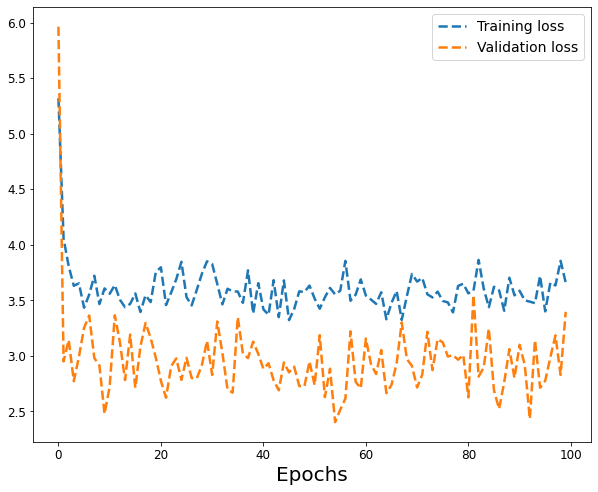

In [48]:
plt.figure(figsize=(10,8))
plt.plot(train_losses,'--',linewidth = 2.5, label='Training loss')
plt.plot(valid_losses,'--', linewidth = 2.5, label='Validation loss')
plt.xlabel('Epochs',fontsize = 20)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12);

# Plotting training/validation accuracy

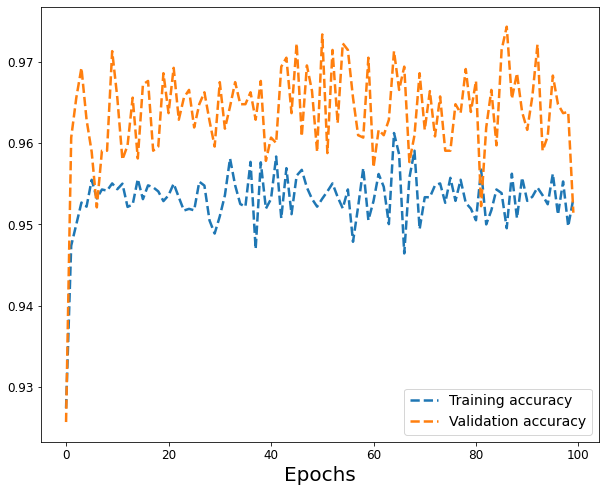

In [49]:
plt.figure(figsize=(10,8))
plt.plot(train_acc,'--', linewidth = 2.5, label='Training accuracy')
plt.plot(valid_acc,'--', linewidth = 2.5, label='Validation accuracy')
plt.xlabel('Epochs', fontsize = 20)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12);

# Loading model with lowest validation loss

In [50]:
res_model.load_state_dict(torch.load('./../models/res_model_pneumonia.pt'))


<All keys matched successfully>

# Testing the model

In [51]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

res_model.eval()
# iterating over test data
for data, target in tqdm(test_loader,  desc = 'Model testing: '):
    # moving tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: computing predicted outputs by passing inputs to the model
    output = res_model(data)
    target = target.long()
    # calculating the batch loss
    loss = criterion(output, target)
    # updating test loss 
    test_loss += loss.item()*data.size(0)
    # converting output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # comparing predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculating test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.291028

Test Accuracy of PNEUMONIA: 77% (182/234)
Test Accuracy of NORMAL: 96% (377/390)

Test Accuracy (Overall): 89% (559/624)


# Evaulating the model

In [52]:
confusion_matrix = torch.zeros(2,2)
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
            output = res_model(data)
            target = target.long()
            _, preds = torch.max(output, 1)
    for t, p in zip(target.view(-1), preds.view(-1)):
        confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[ 6.,  1.],
        [ 0., 17.]])


In [53]:
cm = confusion_matrix.numpy()
tn, fp, fn, tp = cm.ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1_score = (2*precision*recall)/(precision+recall)
print("Precision: {:.4f}\nRecall: {:.4f}\nF1 Score: {:.4f}".format(precision,recall,f1_score))

Precision: 0.9444
Recall: 1.0000
F1 Score: 0.9714


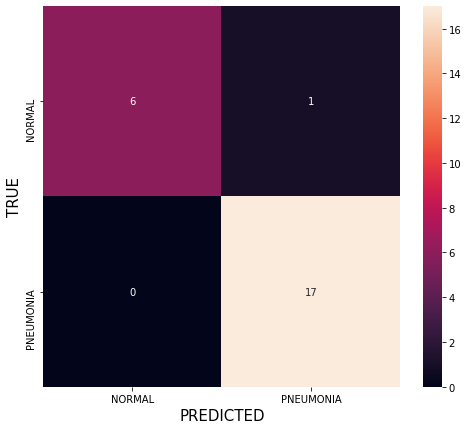

In [54]:
plt.figure(figsize=(8,7))
xticks = np.array(['NORMAL','PNEUMONIA'])
sns.heatmap(cm, annot = True, xticklabels = xticks, yticklabels = xticks)
plt.xlabel('PREDICTED',fontsize = 15)
plt.ylabel('TRUE',fontsize = 15);

# Visualising predicted results 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


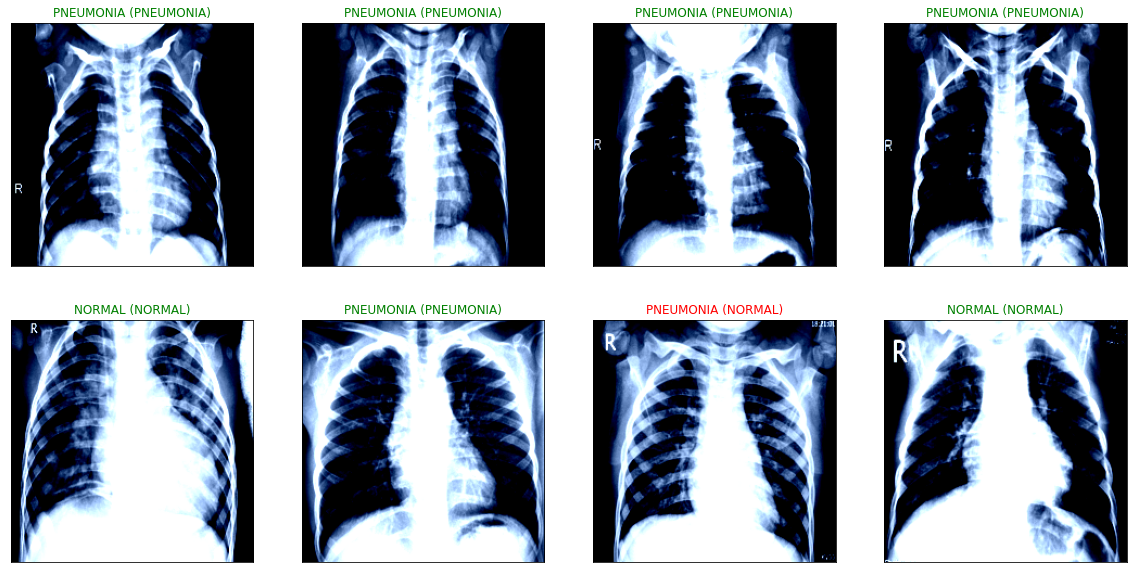

In [55]:
# obtaining one batch of test images
data, target = next(iter(test_loader))
data.numpy()

# moving model inputs to cuda, if GPU available
if train_on_gpu:
    data = data.cuda()

# getting sample outputs
output = res_model(data)

# converting output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plotting the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(20,10))
for idx in np.arange(8):
    ax = fig.add_subplot(2,4, idx+1, xticks=[], yticks=[])
    ax.imshow(data[idx].permute(1, 2, 0) if not train_on_gpu else data[idx].cpu().permute(1, 2, 0))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[target[idx]]),
                 color=("green" if preds[idx]==target[idx] else "red"))

# VGG16

In [56]:
vgg16 = models.vgg16(pretrained=True)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [57]:
# Freezing training for all "features" layers
for param in vgg16.features.parameters():
    param.requires_grad = False

In [58]:
# Adding final layers
vgg16.fc = nn.Sequential(nn.Linear(4096,512),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.Dropout(0.5),
                         nn.Linear(512,2),
                         nn.LogSoftmax(dim=1)) 

In [59]:
# specifying the loss function (categorical cross-entropy)

criterion = nn.CrossEntropyLoss()

# specifying optimizer

optimizer = optim.SGD(vgg16.parameters(), lr = 0.008,momentum = 0.9, nesterov = True)

# specifying scheduler

scheduler = optim.lr_scheduler.ExponentialLR(optimizer,gamma = 0.2)

if train_on_gpu:
    vgg16.cuda()

print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1


# Training and validating the model


In [60]:
# number of epochs to train the model
n_epochs = 100

valid_loss_min = np.Inf # track change in validation loss
train_losses, valid_losses = [], []
train_acc, valid_acc = [], []
for epoch in tqdm(range(1, n_epochs+1), desc = 'Model Training/Epoch: '):

    # keeping track of loss and accuracy
    train_loss = 0.0
    valid_loss = 0.0
    train_accuracy = 0.0
    valid_accuracy = 0.0

    ######################
    # training the model #
    ######################
    vgg16.train()
    for data, target in tqdm(train_loader, desc = 'Model train: '):
        # moving tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clearing the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: computing predicted outputs by passing inputs to the model
        output = vgg16(data)
        target = target.long()
        # calculating the batch loss
        loss = criterion(output, target)
        # backward pass: computing gradient of the loss with respect to model parameters
        loss.backward()
        # performing a single optimization step (parameter update)
        optimizer.step()
        # updating training loss
        train_loss += loss.item()*data.size(0)
        # updating training accuracy
        train_accuracy += accuracy(output,target)
        
    scheduler.step() # decay LR

    ########################  
    # validating the model #
    ########################
    vgg16.eval()
    for data, target in tqdm(valid_loader, desc = 'Model validation: '):
        # moving tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: computing predicted outputs by passing inputs to the model
        output = vgg16(data)
        target = target.long()
        # calculating the batch loss
        loss = criterion(output, target)
        # updating average validation loss 
        valid_loss += loss.item()*data.size(0)
        # updating validation accuracy
        valid_accuracy += accuracy(output,target)
    
    # calculating average losses
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)

    # calculating average accuracy
    train_accuracy = train_accuracy/len(train_loader)
    valid_accuracy = valid_accuracy/len(valid_loader)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_acc.append(train_accuracy)
    valid_acc.append(valid_accuracy)
      
    # printing training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \n\t\tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch, train_loss, valid_loss, train_accuracy, valid_accuracy))
    
    # saving model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(vgg16.state_dict(), './../models/vgg16_pneumonia.pt')
        valid_loss_min = valid_loss


Epoch: 1 	Training Loss: 17.667350 	Validation Loss: 3.737621 
		Training Accuracy: 0.877858 	Validation Accuracy: 0.947326
Validation loss decreased (inf --> 3.737621).  Saving model ...



Epoch: 2 	Training Loss: 4.178199 	Validation Loss: 2.551276 
		Training Accuracy: 0.949614 	Validation Accuracy: 0.969377
Validation loss decreased (3.737621 --> 2.551276).  Saving model ...



Epoch: 3 	Training Loss: 3.317313 	Validation Loss: 2.644777 
		Training Accuracy: 0.957917 	Validation Accuracy: 0.967473



Epoch: 4 	Training Loss: 3.085204 	Validation Loss: 2.578371 
		Training Accuracy: 0.963125 	Validation Accuracy: 0.969377



Epoch: 5 	Training Loss: 3.165493 	Validation Loss: 2.704832 
		Training Accuracy: 0.960953 	Validation Accuracy: 0.970330



Epoch: 6 	Training Loss: 3.229269 	Validation Loss: 2.836529 
		Training Accuracy: 0.963572 	Validation Accuracy: 0.962857



Epoch: 7 	Training Loss: 3.059022 	Validation Loss: 2.540645 
		Training Accuracy: 0.962411 	Validation Accuracy: 0.965568
Validation loss decreased (2.551276 --> 2.540645).  Saving model ...



Epoch: 8 	Training Loss: 3.013145 	Validation Loss: 2.771429 
		Training Accuracy: 0.962917 	Validation Accuracy: 0.961758



Epoch: 9 	Training Loss: 3.195320 	Validation Loss: 2.713270 
		Training Accuracy: 0.961220 	Validation Accuracy: 0.970330



Epoch: 10 	Training Loss: 2.864906 	Validation Loss: 2.640942 
		Training Accuracy: 0.965060 	Validation Accuracy: 0.966520



Epoch: 11 	Training Loss: 3.058229 	Validation Loss: 2.645853 
		Training Accuracy: 0.962887 	Validation Accuracy: 0.963663



Epoch: 12 	Training Loss: 3.188041 	Validation Loss: 2.580250 
		Training Accuracy: 0.959107 	Validation Accuracy: 0.969377



Epoch: 13 	Training Loss: 3.293026 	Validation Loss: 2.529081 
		Training Accuracy: 0.962173 	Validation Accuracy: 0.968425
Validation loss decreased (2.540645 --> 2.529081).  Saving model ...



Epoch: 14 	Training Loss: 3.075837 	Validation Loss: 2.707670 
		Training Accuracy: 0.962679 	Validation Accuracy: 0.965421



Epoch: 15 	Training Loss: 3.089580 	Validation Loss: 2.626421 
		Training Accuracy: 0.960476 	Validation Accuracy: 0.972088



Epoch: 16 	Training Loss: 3.201968 	Validation Loss: 2.437015 
		Training Accuracy: 0.960715 	Validation Accuracy: 0.968571
Validation loss decreased (2.529081 --> 2.437015).  Saving model ...



Epoch: 17 	Training Loss: 3.028969 	Validation Loss: 2.686520 
		Training Accuracy: 0.962381 	Validation Accuracy: 0.967619



Epoch: 18 	Training Loss: 3.078695 	Validation Loss: 2.777402 
		Training Accuracy: 0.960000 	Validation Accuracy: 0.965421



Epoch: 19 	Training Loss: 3.057311 	Validation Loss: 2.530627 
		Training Accuracy: 0.965030 	Validation Accuracy: 0.970476



Epoch: 20 	Training Loss: 2.879777 	Validation Loss: 2.599185 
		Training Accuracy: 0.964792 	Validation Accuracy: 0.968278



Epoch: 21 	Training Loss: 3.171468 	Validation Loss: 2.506772 
		Training Accuracy: 0.960238 	Validation Accuracy: 0.968278



Epoch: 22 	Training Loss: 3.144134 	Validation Loss: 2.307255 
		Training Accuracy: 0.962619 	Validation Accuracy: 0.969377
Validation loss decreased (2.437015 --> 2.307255).  Saving model ...



Epoch: 23 	Training Loss: 3.090208 	Validation Loss: 2.330842 
		Training Accuracy: 0.962917 	Validation Accuracy: 0.968571



Epoch: 24 	Training Loss: 3.272624 	Validation Loss: 2.495125 
		Training Accuracy: 0.959346 	Validation Accuracy: 0.969377



Epoch: 25 	Training Loss: 3.465077 	Validation Loss: 2.216696 
		Training Accuracy: 0.954375 	Validation Accuracy: 0.971429
Validation loss decreased (2.307255 --> 2.216696).  Saving model ...



Epoch: 26 	Training Loss: 3.084881 	Validation Loss: 2.701689 
		Training Accuracy: 0.957143 	Validation Accuracy: 0.963809



Epoch: 27 	Training Loss: 3.038011 	Validation Loss: 2.643992 
		Training Accuracy: 0.960953 	Validation Accuracy: 0.968425



Epoch: 28 	Training Loss: 3.050145 	Validation Loss: 2.572652 
		Training Accuracy: 0.960744 	Validation Accuracy: 0.969524



Epoch: 29 	Training Loss: 3.352974 	Validation Loss: 2.464735 
		Training Accuracy: 0.958393 	Validation Accuracy: 0.971429



Epoch: 30 	Training Loss: 3.131793 	Validation Loss: 2.631704 
		Training Accuracy: 0.963334 	Validation Accuracy: 0.964762



Epoch: 31 	Training Loss: 3.210741 	Validation Loss: 2.712665 
		Training Accuracy: 0.960000 	Validation Accuracy: 0.969377



Epoch: 32 	Training Loss: 3.097784 	Validation Loss: 2.453748 
		Training Accuracy: 0.960030 	Validation Accuracy: 0.968571



Epoch: 33 	Training Loss: 2.993579 	Validation Loss: 2.700142 
		Training Accuracy: 0.960000 	Validation Accuracy: 0.964615



Epoch: 34 	Training Loss: 3.008549 	Validation Loss: 2.708023 
		Training Accuracy: 0.961459 	Validation Accuracy: 0.964616



Epoch: 35 	Training Loss: 3.224409 	Validation Loss: 2.819792 
		Training Accuracy: 0.958661 	Validation Accuracy: 0.967619



Epoch: 36 	Training Loss: 3.206897 	Validation Loss: 2.437948 
		Training Accuracy: 0.960477 	Validation Accuracy: 0.969524



Epoch: 37 	Training Loss: 2.940715 	Validation Loss: 2.613734 
		Training Accuracy: 0.961935 	Validation Accuracy: 0.967472



Epoch: 38 	Training Loss: 2.964604 	Validation Loss: 2.667775 
		Training Accuracy: 0.963810 	Validation Accuracy: 0.966520



Epoch: 39 	Training Loss: 3.066457 	Validation Loss: 2.635818 
		Training Accuracy: 0.963571 	Validation Accuracy: 0.962564



Epoch: 40 	Training Loss: 3.274643 	Validation Loss: 2.293757 
		Training Accuracy: 0.961221 	Validation Accuracy: 0.966667



Epoch: 41 	Training Loss: 3.145790 	Validation Loss: 2.705035 
		Training Accuracy: 0.962649 	Validation Accuracy: 0.966374



Epoch: 42 	Training Loss: 3.185913 	Validation Loss: 2.724364 
		Training Accuracy: 0.963095 	Validation Accuracy: 0.965714



Epoch: 43 	Training Loss: 3.124463 	Validation Loss: 2.504432 
		Training Accuracy: 0.960715 	Validation Accuracy: 0.970476



Epoch: 44 	Training Loss: 3.029422 	Validation Loss: 2.544516 
		Training Accuracy: 0.961221 	Validation Accuracy: 0.964469



Epoch: 45 	Training Loss: 3.240280 	Validation Loss: 2.597324 
		Training Accuracy: 0.958602 	Validation Accuracy: 0.964615



Epoch: 46 	Training Loss: 3.115454 	Validation Loss: 2.316215 
		Training Accuracy: 0.961905 	Validation Accuracy: 0.980000



Epoch: 47 	Training Loss: 2.816770 	Validation Loss: 2.352490 
		Training Accuracy: 0.964584 	Validation Accuracy: 0.969377



Epoch: 48 	Training Loss: 3.372668 	Validation Loss: 2.554384 
		Training Accuracy: 0.955953 	Validation Accuracy: 0.963516



Epoch: 49 	Training Loss: 3.070006 	Validation Loss: 2.557437 
		Training Accuracy: 0.962649 	Validation Accuracy: 0.965421



Epoch: 50 	Training Loss: 3.329403 	Validation Loss: 2.594191 
		Training Accuracy: 0.959345 	Validation Accuracy: 0.967619



Epoch: 51 	Training Loss: 3.188780 	Validation Loss: 2.588759 
		Training Accuracy: 0.961191 	Validation Accuracy: 0.968425



Epoch: 52 	Training Loss: 3.071174 	Validation Loss: 2.539120 
		Training Accuracy: 0.960238 	Validation Accuracy: 0.964469



Epoch: 53 	Training Loss: 3.312355 	Validation Loss: 2.842193 
		Training Accuracy: 0.958601 	Validation Accuracy: 0.964616



Epoch: 54 	Training Loss: 3.002052 	Validation Loss: 2.548175 
		Training Accuracy: 0.963601 	Validation Accuracy: 0.968425



Epoch: 55 	Training Loss: 3.342660 	Validation Loss: 2.738044 
		Training Accuracy: 0.961905 	Validation Accuracy: 0.969524



Epoch: 56 	Training Loss: 3.329132 	Validation Loss: 2.625427 
		Training Accuracy: 0.961667 	Validation Accuracy: 0.971282



Epoch: 57 	Training Loss: 2.978728 	Validation Loss: 2.803549 
		Training Accuracy: 0.961220 	Validation Accuracy: 0.962711



Epoch: 58 	Training Loss: 3.086485 	Validation Loss: 2.710947 
		Training Accuracy: 0.960715 	Validation Accuracy: 0.964762



Epoch: 59 	Training Loss: 2.952445 	Validation Loss: 2.523361 
		Training Accuracy: 0.961905 	Validation Accuracy: 0.971282



Epoch: 60 	Training Loss: 3.047914 	Validation Loss: 2.708597 
		Training Accuracy: 0.962411 	Validation Accuracy: 0.970476



Epoch: 61 	Training Loss: 3.132514 	Validation Loss: 2.607742 
		Training Accuracy: 0.963363 	Validation Accuracy: 0.967180



Epoch: 62 	Training Loss: 3.107331 	Validation Loss: 2.515906 
		Training Accuracy: 0.960000 	Validation Accuracy: 0.968425



Epoch: 63 	Training Loss: 3.232370 	Validation Loss: 2.358983 
		Training Accuracy: 0.958571 	Validation Accuracy: 0.974945



Epoch: 64 	Training Loss: 3.106707 	Validation Loss: 2.614070 
		Training Accuracy: 0.957887 	Validation Accuracy: 0.972234



Epoch: 65 	Training Loss: 3.175229 	Validation Loss: 2.786850 
		Training Accuracy: 0.960060 	Validation Accuracy: 0.964762



Epoch: 66 	Training Loss: 3.235923 	Validation Loss: 2.581825 
		Training Accuracy: 0.958155 	Validation Accuracy: 0.963809



Epoch: 67 	Training Loss: 3.054971 	Validation Loss: 2.880507 
		Training Accuracy: 0.960744 	Validation Accuracy: 0.960806



Epoch: 68 	Training Loss: 3.241127 	Validation Loss: 2.349994 
		Training Accuracy: 0.960238 	Validation Accuracy: 0.969231



Epoch: 69 	Training Loss: 3.240683 	Validation Loss: 2.695304 
		Training Accuracy: 0.959524 	Validation Accuracy: 0.964616



Epoch: 70 	Training Loss: 3.350330 	Validation Loss: 2.726052 
		Training Accuracy: 0.959554 	Validation Accuracy: 0.969524



Epoch: 71 	Training Loss: 3.130748 	Validation Loss: 2.859330 
		Training Accuracy: 0.964524 	Validation Accuracy: 0.967473



Epoch: 72 	Training Loss: 3.063134 	Validation Loss: 2.639600 
		Training Accuracy: 0.962203 	Validation Accuracy: 0.962710



Epoch: 73 	Training Loss: 3.239754 	Validation Loss: 2.465410 
		Training Accuracy: 0.959078 	Validation Accuracy: 0.973993



Epoch: 74 	Training Loss: 3.128110 	Validation Loss: 2.636752 
		Training Accuracy: 0.960030 	Validation Accuracy: 0.966374



Epoch: 75 	Training Loss: 3.264820 	Validation Loss: 2.534028 
		Training Accuracy: 0.960298 	Validation Accuracy: 0.969377



Epoch: 76 	Training Loss: 3.103342 	Validation Loss: 2.579977 
		Training Accuracy: 0.961429 	Validation Accuracy: 0.967619



Epoch: 77 	Training Loss: 3.168887 	Validation Loss: 2.510801 
		Training Accuracy: 0.959554 	Validation Accuracy: 0.972234



Epoch: 78 	Training Loss: 3.279042 	Validation Loss: 2.703624 
		Training Accuracy: 0.957887 	Validation Accuracy: 0.968278



Epoch: 79 	Training Loss: 2.880642 	Validation Loss: 2.765621 
		Training Accuracy: 0.963601 	Validation Accuracy: 0.964762



Epoch: 80 	Training Loss: 3.227795 	Validation Loss: 2.657454 
		Training Accuracy: 0.960477 	Validation Accuracy: 0.964762



Epoch: 81 	Training Loss: 3.234135 	Validation Loss: 2.479020 
		Training Accuracy: 0.960715 	Validation Accuracy: 0.965421



Epoch: 82 	Training Loss: 3.084176 	Validation Loss: 2.702847 
		Training Accuracy: 0.963096 	Validation Accuracy: 0.969231



Epoch: 83 	Training Loss: 2.980287 	Validation Loss: 2.154894 
		Training Accuracy: 0.961429 	Validation Accuracy: 0.976190
Validation loss decreased (2.216696 --> 2.154894).  Saving model ...



Epoch: 84 	Training Loss: 3.100980 	Validation Loss: 2.506936 
		Training Accuracy: 0.960000 	Validation Accuracy: 0.968425



Epoch: 85 	Training Loss: 3.017507 	Validation Loss: 2.597001 
		Training Accuracy: 0.963661 	Validation Accuracy: 0.972234



Epoch: 86 	Training Loss: 2.962877 	Validation Loss: 2.433483 
		Training Accuracy: 0.962857 	Validation Accuracy: 0.968571



Epoch: 87 	Training Loss: 3.190441 	Validation Loss: 2.720800 
		Training Accuracy: 0.959524 	Validation Accuracy: 0.968571



Epoch: 88 	Training Loss: 3.147300 	Validation Loss: 2.570401 
		Training Accuracy: 0.959286 	Validation Accuracy: 0.967619



Epoch: 89 	Training Loss: 3.232334 	Validation Loss: 2.645331 
		Training Accuracy: 0.958810 	Validation Accuracy: 0.971282



Epoch: 90 	Training Loss: 3.267955 	Validation Loss: 2.681733 
		Training Accuracy: 0.961250 	Validation Accuracy: 0.969524



Epoch: 91 	Training Loss: 3.189661 	Validation Loss: 2.560663 
		Training Accuracy: 0.960268 	Validation Accuracy: 0.971429



Epoch: 92 	Training Loss: 3.080562 	Validation Loss: 2.638019 
		Training Accuracy: 0.961905 	Validation Accuracy: 0.965421



Epoch: 93 	Training Loss: 3.319650 	Validation Loss: 2.569783 
		Training Accuracy: 0.961697 	Validation Accuracy: 0.969377



Epoch: 94 	Training Loss: 3.181800 	Validation Loss: 2.748830 
		Training Accuracy: 0.961667 	Validation Accuracy: 0.962857



Epoch: 95 	Training Loss: 3.117088 	Validation Loss: 2.466863 
		Training Accuracy: 0.957679 	Validation Accuracy: 0.967473



Epoch: 96 	Training Loss: 3.198888 	Validation Loss: 2.496233 
		Training Accuracy: 0.959078 	Validation Accuracy: 0.968425



Epoch: 97 	Training Loss: 3.200422 	Validation Loss: 2.530464 
		Training Accuracy: 0.956905 	Validation Accuracy: 0.967619



Epoch: 98 	Training Loss: 3.093969 	Validation Loss: 2.485638 
		Training Accuracy: 0.959524 	Validation Accuracy: 0.970476



Epoch: 99 	Training Loss: 3.180388 	Validation Loss: 2.550592 
		Training Accuracy: 0.957887 	Validation Accuracy: 0.966374



Epoch: 100 	Training Loss: 3.258148 	Validation Loss: 2.847490 
		Training Accuracy: 0.959316 	Validation Accuracy: 0.964762



# Plotting training/validation losses

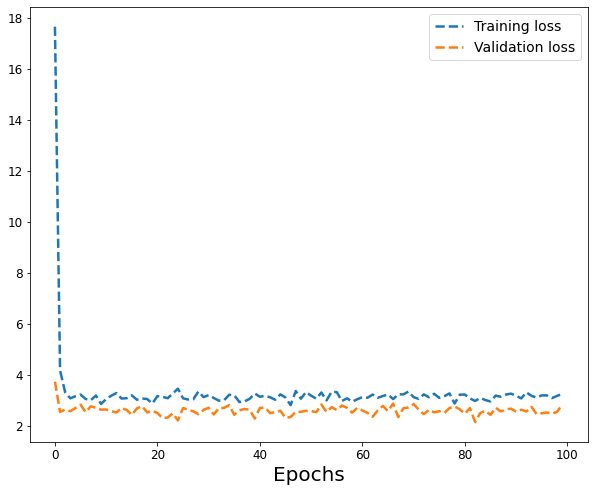

In [61]:
plt.figure(figsize=(10,8))
plt.plot(train_losses,'--',linewidth = 2.5, label='Training loss')
plt.plot(valid_losses,'--', linewidth = 2.5, label='Validation loss')
plt.xlabel('Epochs',fontsize = 20)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12);

# Plotting training/validation accuracy

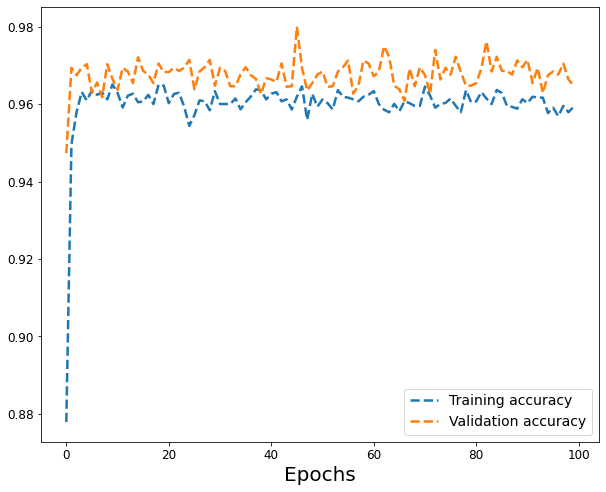

In [62]:
plt.figure(figsize=(10,8))
plt.plot(train_acc,'--', linewidth = 2.5, label='Training accuracy')
plt.plot(valid_acc,'--', linewidth = 2.5, label='Validation accuracy')
plt.xlabel('Epochs', fontsize = 20)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12);

# Loading model with lowest validation loss

In [63]:
vgg16.load_state_dict(torch.load('./../models/vgg16_pneumonia.pt'))

<All keys matched successfully>

# Testing the model

In [64]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

vgg16.eval()
# iterating over test data
for data, target in tqdm(test_loader, desc = 'Model testing: '):
    # moving tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: computing predicted outputs by passing inputs to the model
    output = vgg16(data)
    target = target.long()
    # calculating the batch loss
    loss = criterion(output, target)
    # updating test loss 
    test_loss += loss.item()*data.size(0)
    # converting output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # comparing predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculating test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.213057

Test Accuracy of PNEUMONIA: 81% (191/234)
Test Accuracy of NORMAL: 96% (378/390)

Test Accuracy (Overall): 91% (569/624)


# Evaulating the model

In [65]:
confusion_matrix = torch.zeros(2,2)
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
            output = vgg16(data)
            target = target.long()
            _, preds = torch.max(output, 1)
        for t, p in zip(target.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[191.,  43.],
        [ 12., 378.]])


In [66]:
cm = confusion_matrix.numpy()
tn, fp, fn, tp = cm.ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1_score = (2*precision*recall)/(precision+recall)
print("Precision: {:.4f}\nRecall: {:.4f}\nF1 Score: {:.4f}".format(precision,recall,f1_score))

Precision: 0.8979
Recall: 0.9692
F1 Score: 0.9322


Text(51.0, 0.5, 'TRUE')

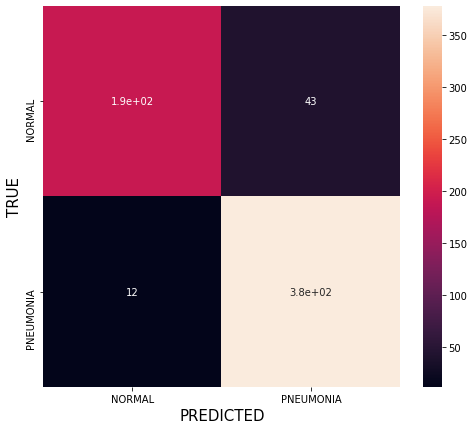

In [67]:
plt.figure(figsize=(8,7))
xticks = np.array(['NORMAL','PNEUMONIA'])
sns.heatmap(cm, annot = True, 
            xticklabels = xticks, yticklabels = xticks)
plt.xlabel('PREDICTED',fontsize = 15)
plt.ylabel('TRUE',fontsize = 15);

# Visualising predicted results 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


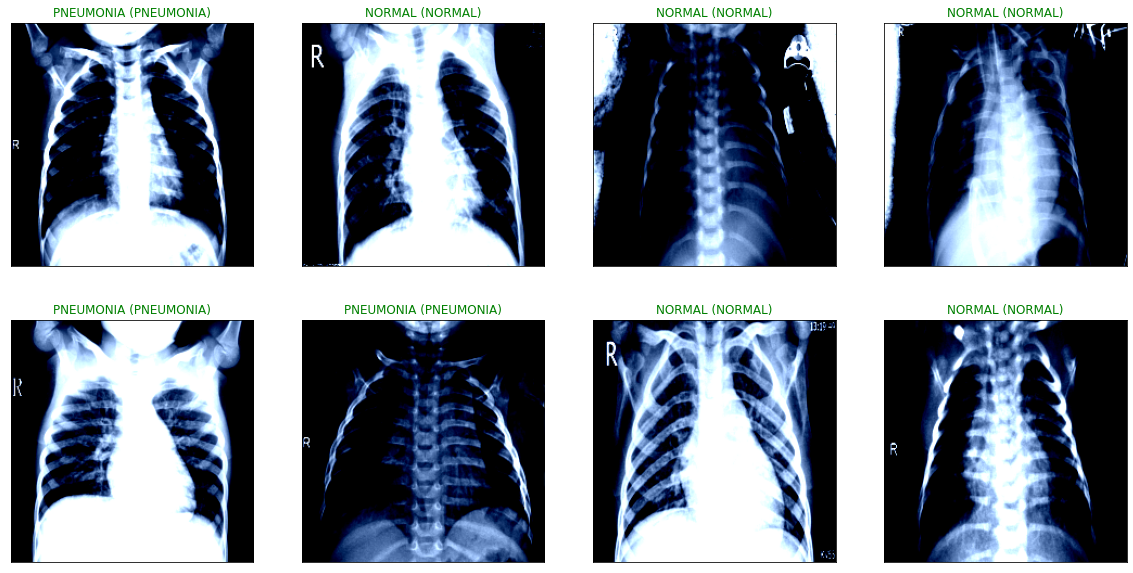

In [68]:
# obtaining one batch of test images
data, target = next(iter(test_loader))
data.numpy()

# moving model inputs to cuda, if GPU available
if train_on_gpu:
    data = data.cuda()

# getting sample outputs
output = vgg16(data)

# converting output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plotting the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(20,10))
for idx in np.arange(8):
    ax = fig.add_subplot(2,4, idx+1, xticks=[], yticks=[])
    ax.imshow(data[idx].permute(1, 2, 0) if not train_on_gpu else data[idx].cpu().permute(1, 2, 0))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[target[idx]]),
                 color=("green" if preds[idx]==target[idx] else "red"))

# VGG 19

In [1]:
vgg19 = models.vgg19(pretrained=True)
print(vgg19)

NameError: name 'models' is not defined

In [70]:
# Freezing training for all "features" layers
for param in vgg19.features.parameters():
    param.requires_grad = False

In [71]:
# Adding final layers
vgg19.fc = nn.Sequential(nn.Linear(4096,512),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.Dropout(0.5),
                         nn.Linear(512,2),
                         nn.LogSoftmax(dim=1)) 

In [72]:
# specifying the loss function (categorical cross-entropy)

criterion = nn.CrossEntropyLoss()

# specifying optimizer

optimizer = optim.SGD(vgg19.parameters(), lr = 0.008, momentum = 0.9, nesterov = True)

# specifying scheduler

scheduler = optim.lr_scheduler.ExponentialLR(optimizer,gamma = 0.2)

if train_on_gpu:
    vgg19.cuda()

print(vgg19)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [73]:
# number of epochs to train the model
n_epochs = 100

valid_loss_min = np.Inf # track change in validation loss
train_losses, valid_losses = [], []
train_acc, valid_acc = [], []
for epoch in tqdm(range(1, n_epochs+1), desc = 'Model Training/Epoch: '):

    # keeping track of loss and accuracy
    train_loss = 0.0
    valid_loss = 0.0
    train_accuracy = 0.0
    valid_accuracy = 0.0

    ######################
    # training the model #
    ######################
    vgg19.train()
    for data, target in tqdm(train_loader, desc = 'Model train: '):
        # moving tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clearing the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: computing predicted outputs by passing inputs to the model
        output = vgg19(data)
        target = target.long()
        # calculating the batch loss
        loss = criterion(output, target)
        # backward pass: computing gradient of the loss with respect to model parameters
        loss.backward()
        # performing a single optimization step (parameter update)
        optimizer.step()
        # updating training loss
        train_loss += loss.item()*data.size(0)
        # updating training accuracy
        train_accuracy += accuracy(output,target)
        
    scheduler.step() # decay LR

    ########################  
    # validating the model #
    ########################
    vgg19.eval()
    for data, target in tqdm(valid_loader, desc = 'Model validation: '):
        # moving tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: computing predicted outputs by passing inputs to the model
        output = vgg19(data)
        target = target.long()
        # calculating the batch loss
        loss = criterion(output, target)
        # updating average validation loss 
        valid_loss += loss.item()*data.size(0)
        # updating validation accuracy
        valid_accuracy += accuracy(output,target)
    
    # calculating average losses
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)

    # calculating average accuracy
    train_accuracy = train_accuracy/len(train_loader)
    valid_accuracy = valid_accuracy/len(valid_loader)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_acc.append(train_accuracy)
    valid_acc.append(valid_accuracy)
      
    # printing training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \n\t\tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch, train_loss, valid_loss, train_accuracy, valid_accuracy))
    
    # saving model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(vgg19.state_dict(), './../models/vgg19_pneumonia.pt')
        valid_loss_min = valid_loss


Epoch: 1 	Training Loss: 13.510141 	Validation Loss: 3.935669 
		Training Accuracy: 0.882679 	Validation Accuracy: 0.948425
Validation loss decreased (inf --> 3.935669).  Saving model ...



Epoch: 2 	Training Loss: 4.334541 	Validation Loss: 3.558420 
		Training Accuracy: 0.949524 	Validation Accuracy: 0.952234
Validation loss decreased (3.935669 --> 3.558420).  Saving model ...



Epoch: 3 	Training Loss: 3.454049 	Validation Loss: 3.205781 
		Training Accuracy: 0.953363 	Validation Accuracy: 0.958095
Validation loss decreased (3.558420 --> 3.205781).  Saving model ...



Epoch: 4 	Training Loss: 3.415587 	Validation Loss: 2.847211 
		Training Accuracy: 0.954762 	Validation Accuracy: 0.960806
Validation loss decreased (3.205781 --> 2.847211).  Saving model ...



Epoch: 5 	Training Loss: 3.489104 	Validation Loss: 3.607472 
		Training Accuracy: 0.954048 	Validation Accuracy: 0.951795



Epoch: 6 	Training Loss: 3.380298 	Validation Loss: 3.082811 
		Training Accuracy: 0.960476 	Validation Accuracy: 0.956044



Epoch: 7 	Training Loss: 3.605634 	Validation Loss: 2.994798 
		Training Accuracy: 0.955744 	Validation Accuracy: 0.961465



Epoch: 8 	Training Loss: 3.310773 	Validation Loss: 2.919432 
		Training Accuracy: 0.957887 	Validation Accuracy: 0.956703



Epoch: 9 	Training Loss: 3.245864 	Validation Loss: 2.913105 
		Training Accuracy: 0.960060 	Validation Accuracy: 0.962564



Epoch: 10 	Training Loss: 3.459905 	Validation Loss: 3.198183 
		Training Accuracy: 0.960715 	Validation Accuracy: 0.958095



Epoch: 11 	Training Loss: 3.613631 	Validation Loss: 2.924762 
		Training Accuracy: 0.959286 	Validation Accuracy: 0.960000



Epoch: 12 	Training Loss: 3.612762 	Validation Loss: 3.187192 
		Training Accuracy: 0.954316 	Validation Accuracy: 0.954286



Epoch: 13 	Training Loss: 3.284087 	Validation Loss: 2.847460 
		Training Accuracy: 0.956250 	Validation Accuracy: 0.962711



Epoch: 14 	Training Loss: 3.242849 	Validation Loss: 3.006502 
		Training Accuracy: 0.960268 	Validation Accuracy: 0.962564



Epoch: 15 	Training Loss: 3.386828 	Validation Loss: 3.158714 
		Training Accuracy: 0.958125 	Validation Accuracy: 0.952234



Epoch: 16 	Training Loss: 3.312329 	Validation Loss: 3.015409 
		Training Accuracy: 0.956697 	Validation Accuracy: 0.959048



Epoch: 17 	Training Loss: 3.560689 	Validation Loss: 2.914869 
		Training Accuracy: 0.955268 	Validation Accuracy: 0.961905



Epoch: 18 	Training Loss: 3.533449 	Validation Loss: 2.908084 
		Training Accuracy: 0.950715 	Validation Accuracy: 0.958901



Epoch: 19 	Training Loss: 3.471468 	Validation Loss: 2.992906 
		Training Accuracy: 0.954554 	Validation Accuracy: 0.956703



Epoch: 20 	Training Loss: 3.430110 	Validation Loss: 2.746312 
		Training Accuracy: 0.952619 	Validation Accuracy: 0.958901
Validation loss decreased (2.847211 --> 2.746312).  Saving model ...



Epoch: 21 	Training Loss: 3.666111 	Validation Loss: 3.123970 
		Training Accuracy: 0.951905 	Validation Accuracy: 0.956996



Epoch: 22 	Training Loss: 3.301889 	Validation Loss: 2.963295 
		Training Accuracy: 0.955536 	Validation Accuracy: 0.959048



Epoch: 23 	Training Loss: 3.122262 	Validation Loss: 3.019467 
		Training Accuracy: 0.958363 	Validation Accuracy: 0.954286



Epoch: 24 	Training Loss: 3.485370 	Validation Loss: 2.955798 
		Training Accuracy: 0.955268 	Validation Accuracy: 0.956996



Epoch: 25 	Training Loss: 3.533084 	Validation Loss: 3.317520 
		Training Accuracy: 0.955030 	Validation Accuracy: 0.953187



Epoch: 26 	Training Loss: 3.486697 	Validation Loss: 2.964122 
		Training Accuracy: 0.956667 	Validation Accuracy: 0.957143



Epoch: 27 	Training Loss: 3.236516 	Validation Loss: 3.061709 
		Training Accuracy: 0.959792 	Validation Accuracy: 0.961905



Epoch: 28 	Training Loss: 3.284637 	Validation Loss: 3.184100 
		Training Accuracy: 0.958810 	Validation Accuracy: 0.959048



Epoch: 29 	Training Loss: 3.580308 	Validation Loss: 3.108135 
		Training Accuracy: 0.954137 	Validation Accuracy: 0.958755



Epoch: 30 	Training Loss: 3.123207 	Validation Loss: 3.051007 
		Training Accuracy: 0.957857 	Validation Accuracy: 0.956997



Epoch: 31 	Training Loss: 3.457726 	Validation Loss: 2.941169 
		Training Accuracy: 0.954316 	Validation Accuracy: 0.962857



Epoch: 32 	Training Loss: 3.342324 	Validation Loss: 2.993522 
		Training Accuracy: 0.958125 	Validation Accuracy: 0.962564



Epoch: 33 	Training Loss: 3.711888 	Validation Loss: 2.902280 
		Training Accuracy: 0.954048 	Validation Accuracy: 0.960952



Epoch: 34 	Training Loss: 3.566735 	Validation Loss: 2.902579 
		Training Accuracy: 0.956429 	Validation Accuracy: 0.962857



Epoch: 35 	Training Loss: 3.291976 	Validation Loss: 3.068246 
		Training Accuracy: 0.956697 	Validation Accuracy: 0.957143



Epoch: 36 	Training Loss: 3.482515 	Validation Loss: 2.886519 
		Training Accuracy: 0.956935 	Validation Accuracy: 0.955897



Epoch: 37 	Training Loss: 3.441705 	Validation Loss: 3.070416 
		Training Accuracy: 0.958810 	Validation Accuracy: 0.955897



Epoch: 38 	Training Loss: 3.265039 	Validation Loss: 2.918490 
		Training Accuracy: 0.960000 	Validation Accuracy: 0.964762



Epoch: 39 	Training Loss: 3.465814 	Validation Loss: 2.951473 
		Training Accuracy: 0.957887 	Validation Accuracy: 0.967619



Epoch: 40 	Training Loss: 3.224375 	Validation Loss: 3.218928 
		Training Accuracy: 0.956935 	Validation Accuracy: 0.959853



Epoch: 41 	Training Loss: 3.251793 	Validation Loss: 3.368749 
		Training Accuracy: 0.958601 	Validation Accuracy: 0.951941



Epoch: 42 	Training Loss: 3.609659 	Validation Loss: 3.005757 
		Training Accuracy: 0.950715 	Validation Accuracy: 0.964615



Epoch: 43 	Training Loss: 3.401568 	Validation Loss: 2.871498 
		Training Accuracy: 0.957619 	Validation Accuracy: 0.964322



Epoch: 44 	Training Loss: 3.456453 	Validation Loss: 3.193111 
		Training Accuracy: 0.959524 	Validation Accuracy: 0.956996



Epoch: 45 	Training Loss: 3.334325 	Validation Loss: 3.158654 
		Training Accuracy: 0.953572 	Validation Accuracy: 0.958901



Epoch: 46 	Training Loss: 3.415161 	Validation Loss: 2.848882 
		Training Accuracy: 0.959286 	Validation Accuracy: 0.963663



Epoch: 47 	Training Loss: 3.310765 	Validation Loss: 2.942414 
		Training Accuracy: 0.958125 	Validation Accuracy: 0.957949



Epoch: 48 	Training Loss: 3.719572 	Validation Loss: 3.049627 
		Training Accuracy: 0.948602 	Validation Accuracy: 0.960806



Epoch: 49 	Training Loss: 3.411166 	Validation Loss: 2.855486 
		Training Accuracy: 0.955953 	Validation Accuracy: 0.957509



Epoch: 50 	Training Loss: 3.524796 	Validation Loss: 2.829436 
		Training Accuracy: 0.955953 	Validation Accuracy: 0.960000



Epoch: 51 	Training Loss: 3.160231 	Validation Loss: 2.928636 
		Training Accuracy: 0.961667 	Validation Accuracy: 0.960952



Epoch: 52 	Training Loss: 3.506489 	Validation Loss: 3.113644 
		Training Accuracy: 0.955268 	Validation Accuracy: 0.957949



Epoch: 53 	Training Loss: 3.367503 	Validation Loss: 3.250704 
		Training Accuracy: 0.956667 	Validation Accuracy: 0.959048



Epoch: 54 	Training Loss: 3.587550 	Validation Loss: 2.905142 
		Training Accuracy: 0.955715 	Validation Accuracy: 0.961758



Epoch: 55 	Training Loss: 3.373432 	Validation Loss: 2.996850 
		Training Accuracy: 0.956191 	Validation Accuracy: 0.957949



Epoch: 56 	Training Loss: 3.496185 	Validation Loss: 2.971601 
		Training Accuracy: 0.955715 	Validation Accuracy: 0.960659



Epoch: 57 	Training Loss: 3.358374 	Validation Loss: 3.140039 
		Training Accuracy: 0.955000 	Validation Accuracy: 0.957143



Epoch: 58 	Training Loss: 3.189660 	Validation Loss: 3.249238 
		Training Accuracy: 0.959078 	Validation Accuracy: 0.952381



Epoch: 59 	Training Loss: 3.596932 	Validation Loss: 2.730829 
		Training Accuracy: 0.952143 	Validation Accuracy: 0.966520
Validation loss decreased (2.746312 --> 2.730829).  Saving model ...



Epoch: 60 	Training Loss: 3.436621 	Validation Loss: 2.758686 
		Training Accuracy: 0.958810 	Validation Accuracy: 0.967472



Epoch: 61 	Training Loss: 3.511800 	Validation Loss: 3.162646 
		Training Accuracy: 0.954762 	Validation Accuracy: 0.955092



Epoch: 62 	Training Loss: 3.441398 	Validation Loss: 2.950811 
		Training Accuracy: 0.955715 	Validation Accuracy: 0.961758



Epoch: 63 	Training Loss: 3.377047 	Validation Loss: 3.012627 
		Training Accuracy: 0.959614 	Validation Accuracy: 0.965421



Epoch: 64 	Training Loss: 3.310835 	Validation Loss: 3.311706 
		Training Accuracy: 0.956429 	Validation Accuracy: 0.952894



Epoch: 65 	Training Loss: 3.330177 	Validation Loss: 3.077992 
		Training Accuracy: 0.955506 	Validation Accuracy: 0.951941



Epoch: 66 	Training Loss: 3.330314 	Validation Loss: 2.579198 
		Training Accuracy: 0.957649 	Validation Accuracy: 0.970183
Validation loss decreased (2.730829 --> 2.579198).  Saving model ...



Epoch: 67 	Training Loss: 3.257892 	Validation Loss: 2.795484 
		Training Accuracy: 0.957887 	Validation Accuracy: 0.958755



Epoch: 68 	Training Loss: 3.336628 	Validation Loss: 3.072439 
		Training Accuracy: 0.955744 	Validation Accuracy: 0.960659



Epoch: 69 	Training Loss: 3.362346 	Validation Loss: 2.784997 
		Training Accuracy: 0.958096 	Validation Accuracy: 0.965714



Epoch: 70 	Training Loss: 3.220004 	Validation Loss: 3.289794 
		Training Accuracy: 0.961220 	Validation Accuracy: 0.952088



Epoch: 71 	Training Loss: 3.320972 	Validation Loss: 3.198232 
		Training Accuracy: 0.957381 	Validation Accuracy: 0.958901



Epoch: 72 	Training Loss: 3.536178 	Validation Loss: 3.194713 
		Training Accuracy: 0.957411 	Validation Accuracy: 0.952088



Epoch: 73 	Training Loss: 3.426154 	Validation Loss: 3.120841 
		Training Accuracy: 0.958631 	Validation Accuracy: 0.958901



Epoch: 74 	Training Loss: 3.265437 	Validation Loss: 3.356003 
		Training Accuracy: 0.957887 	Validation Accuracy: 0.956996



Epoch: 75 	Training Loss: 3.439150 	Validation Loss: 3.091171 
		Training Accuracy: 0.957649 	Validation Accuracy: 0.956996



Epoch: 76 	Training Loss: 3.465368 	Validation Loss: 2.794633 
		Training Accuracy: 0.954078 	Validation Accuracy: 0.962857



Epoch: 77 	Training Loss: 3.486829 	Validation Loss: 3.017923 
		Training Accuracy: 0.951697 	Validation Accuracy: 0.960806



Epoch: 78 	Training Loss: 3.612007 	Validation Loss: 3.214564 
		Training Accuracy: 0.954286 	Validation Accuracy: 0.956996



Epoch: 79 	Training Loss: 3.410268 	Validation Loss: 3.353851 
		Training Accuracy: 0.954792 	Validation Accuracy: 0.953846



Epoch: 80 	Training Loss: 3.412967 	Validation Loss: 3.363153 
		Training Accuracy: 0.957619 	Validation Accuracy: 0.950329



Epoch: 81 	Training Loss: 3.434409 	Validation Loss: 3.114588 
		Training Accuracy: 0.957143 	Validation Accuracy: 0.961758



Epoch: 82 	Training Loss: 3.435157 	Validation Loss: 2.891220 
		Training Accuracy: 0.960476 	Validation Accuracy: 0.957143



Epoch: 83 	Training Loss: 3.539886 	Validation Loss: 3.095615 
		Training Accuracy: 0.951905 	Validation Accuracy: 0.958755



Epoch: 84 	Training Loss: 3.255761 	Validation Loss: 2.973506 
		Training Accuracy: 0.960536 	Validation Accuracy: 0.959048



Epoch: 85 	Training Loss: 3.418598 	Validation Loss: 3.146672 
		Training Accuracy: 0.955030 	Validation Accuracy: 0.955092



Epoch: 86 	Training Loss: 3.410447 	Validation Loss: 2.851292 
		Training Accuracy: 0.955000 	Validation Accuracy: 0.966520



Epoch: 87 	Training Loss: 3.395330 	Validation Loss: 3.016580 
		Training Accuracy: 0.955476 	Validation Accuracy: 0.962711



Epoch: 88 	Training Loss: 3.150888 	Validation Loss: 3.139933 
		Training Accuracy: 0.960268 	Validation Accuracy: 0.960000



Epoch: 89 	Training Loss: 3.449000 	Validation Loss: 3.116051 
		Training Accuracy: 0.958601 	Validation Accuracy: 0.960952



Epoch: 90 	Training Loss: 3.275479 	Validation Loss: 3.254880 
		Training Accuracy: 0.958334 	Validation Accuracy: 0.957949



Epoch: 91 	Training Loss: 3.290689 	Validation Loss: 2.742065 
		Training Accuracy: 0.955715 	Validation Accuracy: 0.966667



Epoch: 92 	Training Loss: 3.631882 	Validation Loss: 2.903477 
		Training Accuracy: 0.952619 	Validation Accuracy: 0.963663



Epoch: 93 	Training Loss: 3.430934 	Validation Loss: 3.000058 
		Training Accuracy: 0.958125 	Validation Accuracy: 0.955604



Epoch: 94 	Training Loss: 3.366206 	Validation Loss: 3.032690 
		Training Accuracy: 0.957709 	Validation Accuracy: 0.959048



Epoch: 95 	Training Loss: 3.562633 	Validation Loss: 3.032979 
		Training Accuracy: 0.952857 	Validation Accuracy: 0.960659



Epoch: 96 	Training Loss: 3.502647 	Validation Loss: 3.049100 
		Training Accuracy: 0.953810 	Validation Accuracy: 0.956703



Epoch: 97 	Training Loss: 3.353789 	Validation Loss: 2.807156 
		Training Accuracy: 0.960953 	Validation Accuracy: 0.961465



Epoch: 98 	Training Loss: 3.397426 	Validation Loss: 3.192062 
		Training Accuracy: 0.955239 	Validation Accuracy: 0.959853



Epoch: 99 	Training Loss: 3.418821 	Validation Loss: 2.892588 
		Training Accuracy: 0.954762 	Validation Accuracy: 0.965421



Epoch: 100 	Training Loss: 3.282185 	Validation Loss: 3.099401 
		Training Accuracy: 0.957887 	Validation Accuracy: 0.955897



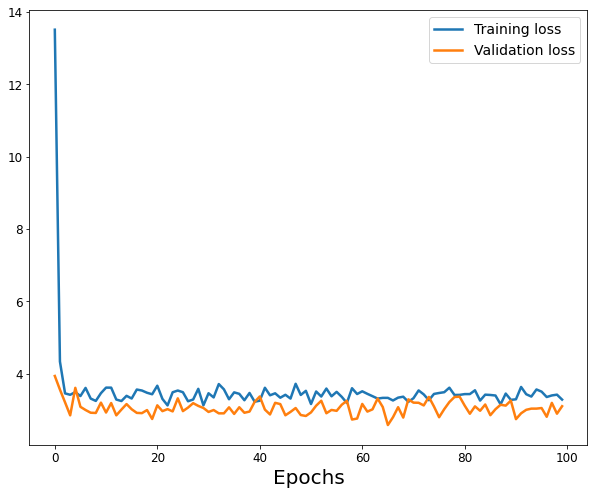

In [75]:
plt.figure(figsize=(10,8))
plt.plot(train_losses,'-',linewidth = 2.5, label='Training loss')
plt.plot(valid_losses,'-', linewidth = 2.5, label='Validation loss')
plt.xlabel('Epochs',fontsize = 20)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12);

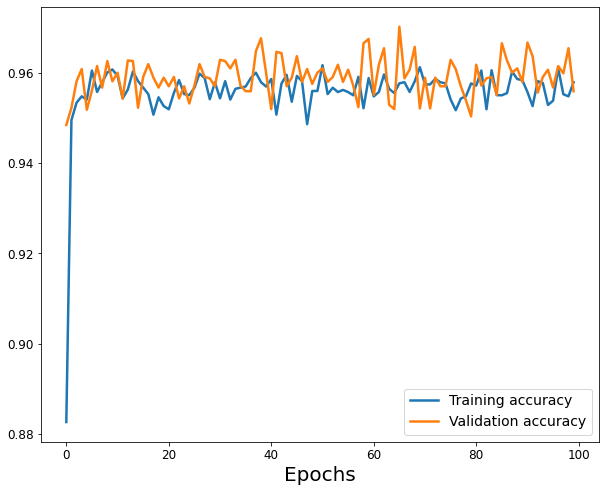

In [76]:
plt.figure(figsize=(10,8))
plt.plot(train_acc,'-', linewidth = 2.5, label='Training accuracy')
plt.plot(valid_acc,'-', linewidth = 2.5, label='Validation accuracy')
plt.xlabel('Epochs', fontsize = 20)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12);

In [77]:
vgg19.load_state_dict(torch.load('./../models/vgg19_pneumonia.pt'))

<All keys matched successfully>

In [ ]:
print('Total pretrained parameters: ', sum(p.numel() for p in model.parameters()) - sum(p.numel() for p in model.parameters() if p.requires_grad))
print('Total trainable parameter: ', sum(p.numel() for p in model.parameters() if p.requires_grad))

In [78]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

vgg16.eval()
# iterating over test data
for data, target in tqdm(test_loader, desc = 'Model testing: '):
    # moving tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: computing predicted outputs by passing inputs to the model
    output = vgg19(data)
    target = target.long()
    # calculating the batch loss
    loss = criterion(output, target)
    # updating test loss 
    test_loss += loss.item()*data.size(0)
    # converting output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # comparing predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculating test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.196179

Test Accuracy of PNEUMONIA: 84% (197/234)
Test Accuracy of NORMAL: 96% (377/390)

Test Accuracy (Overall): 91% (574/624)


In [79]:
confusion_matrix = torch.zeros(2,2)
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
            output = vgg19(data)
            target = target.long()
            _, preds = torch.max(output, 1)
        for t, p in zip(target.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[197.,  37.],
        [ 13., 377.]])


In [82]:
cm = confusion_matrix.numpy()
tn, fp, fn, tp = cm.ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1_score = (2*precision*recall)/(precision+recall)
print("Precision: {:.4f}\nRecall: {:.4f}\nF1 Score: {:.4f}".format(precision,recall,f1_score))

Precision: 0.9106
Recall: 0.9667
F1 Score: 0.9378


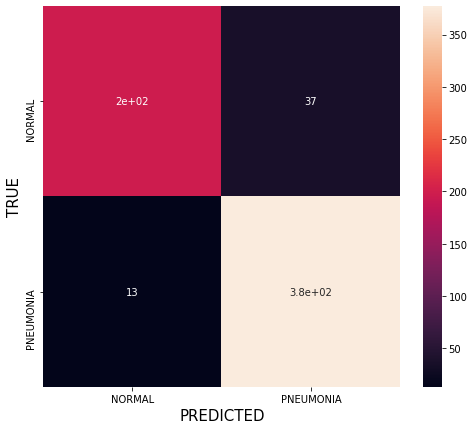

In [83]:
plt.figure(figsize=(8,7))
xticks = np.array(['NORMAL','PNEUMONIA'])
sns.heatmap(cm, annot = True, 
            xticklabels = xticks, yticklabels = xticks)
plt.xlabel('PREDICTED',fontsize = 15)
plt.ylabel('TRUE',fontsize = 15);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


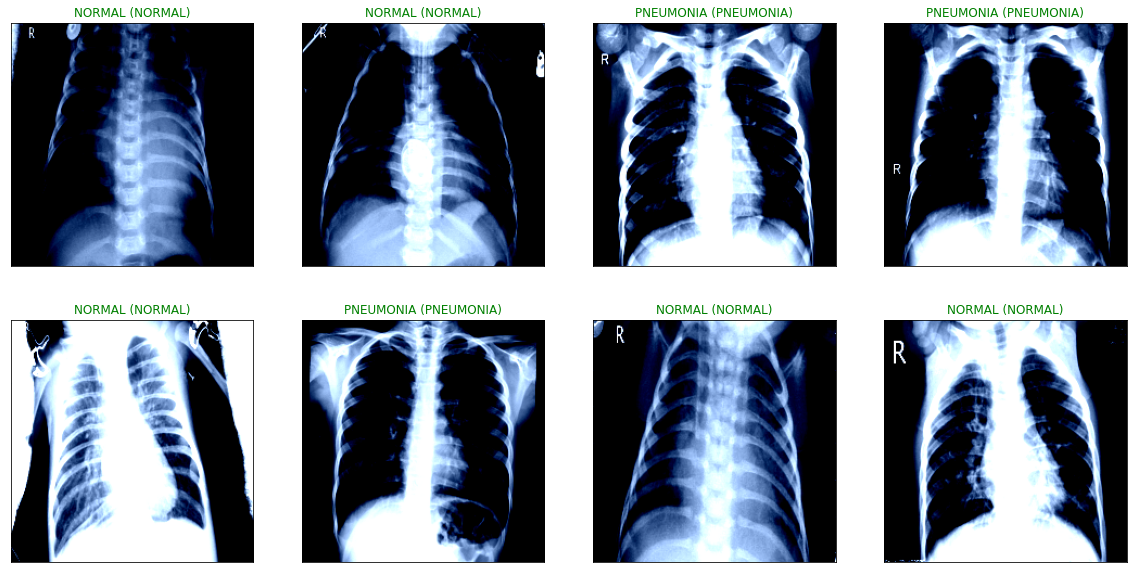

In [84]:
# obtaining one batch of test images
data, target = next(iter(test_loader))
data.numpy()

# moving model inputs to cuda, if GPU available
if train_on_gpu:
    data = data.cuda()

# getting sample outputs
output = vgg19(data)

# converting output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plotting the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(20,10))
for idx in np.arange(8):
    ax = fig.add_subplot(2,4, idx+1, xticks=[], yticks=[])
    ax.imshow(data[idx].permute(1, 2, 0) if not train_on_gpu else data[idx].cpu().permute(1, 2, 0))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[target[idx]]),
                 color=("green" if preds[idx]==target[idx] else "red"))